In [13]:
!pip install shap
import shap

shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.1 MB/s eta 0:00:00


In [1]:
# step1
import pandas as pd
import numpy as np
df = pd.read_csv('0109tryinputmodelC.csv')
df_groundtruth_csv = pd.read_csv('ground_truth.csv')
print("len df", len(df)) #2840*24
print(df.isna().sum())
# drop the row having nan
df = df.dropna(axis=0, how='any')
print("len df", len(df)) #2774*24  66
print(df.isna().sum())
# replace inf with zero
df.replace([np.inf, -np.inf], 0, inplace=True)

"""
# Assuming your DataFrame is named df
df['charttime'] = pd.to_datetime(df['charttime'])  # Convert to datetime if not already
df.sort_values(['stay_id', 'charttime'], inplace=True)  # Sort by stay_id and charttime

# Calculate the 'before_weaning_hr' column
df['before_weaning_hr'] = df.groupby('stay_id').cumcount(ascending=False)

# Resetting index (optional)
df.reset_index(drop=True, inplace=True)

# compute BMI
df['BMI'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)

# drop need drop column
df = df.drop(['Unnamed: 0', 'Rev_h', 'dod_h'], axis=1) # 'subject_id', 'hadm_id', 'stay_id',
"""
df = df.drop(['Unnamed: 0'], axis=1)
print(df.columns)
# add 01 label
df = df.drop(['label'], axis=1)
df_groundtruth = df_groundtruth_csv[['stay_id', 'label']]
df = pd.merge(df, df_groundtruth, on=['stay_id'], how='inner')
"""
# transform the (type is object) column to one hot encoding
cols_need_one_hot_encoding = ['gender', 'race','admission_type', 'first_careunit', 'insurance'] #, 'ventilator_mode_group']
one_hot_encoding = pd.get_dummies(df[cols_need_one_hot_encoding])
df_with_one_hot_encoding = df.join(one_hot_encoding) # df.join default index-on-index
df_with_one_hot_encoding
"""
print(df.columns)
df_with_one_hot_encoding_drop_not_num = df

len df 2663
Unnamed: 0               0
stay_id                  0
heart_rate               0
sbp                      0
dbp                      0
mbp                      0
spo2                     0
resp_rate                0
tidal_volume_observed    0
RSBI                     0
minute_ventilation       0
peep                     0
fio2                     0
respiratory_rate_set     0
plateau_pressure         0
age_now                  0
gender                   0
race                     0
BMI                      0
tobacco                  0
BMI.1                    0
GCS                      0
count_complete_mode      0
std peep                 0
std plateau_pressure     0
label                    0
dtype: int64
len df 2663
Unnamed: 0               0
stay_id                  0
heart_rate               0
sbp                      0
dbp                      0
mbp                      0
spo2                     0
resp_rate                0
tidal_volume_observed    0
RSBI              

In [2]:
# candelete
print(df.columns)
print("tr_v", len(df)) #2132
print(df.isna().sum())

Index(['stay_id', 'heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate',
       'tidal_volume_observed', 'RSBI', 'minute_ventilation', 'peep', 'fio2',
       'respiratory_rate_set', 'plateau_pressure', 'age_now', 'gender', 'race',
       'BMI', 'tobacco', 'BMI.1', 'GCS', 'count_complete_mode', 'std peep',
       'std plateau_pressure', 'label'],
      dtype='object')
tr_v 899
stay_id                  0
heart_rate               0
sbp                      0
dbp                      0
mbp                      0
spo2                     0
resp_rate                0
tidal_volume_observed    0
RSBI                     0
minute_ventilation       0
peep                     0
fio2                     0
respiratory_rate_set     0
plateau_pressure         0
age_now                  0
gender                   0
race                     0
BMI                      0
tobacco                  0
BMI.1                    0
GCS                      0
count_complete_mode      0
std peep                 0

In [3]:
# step2
# import
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GroupShuffleSplit # used to separated data
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# draw decision tree
from io import StringIO
import numpy as np
from sklearn import tree
import pydotplus
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz
import csv

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# step3
# split data
# drop type which is not float or not int

"""
# drop do one hot encoding #, 'ventilator_mode_group'
df_with_one_hot_encoding_drop_not_num = df_with_one_hot_encoding.drop([ 'weight_kg', 'height_cm', 'charttime',  'gender', 'race','admission_type', 'first_careunit', 'insurance'], axis=1)

# the before_weaning_hr we want
print_before_weaning_hr = 0
df_with_one_hot_encoding_drop_not_num = df_with_one_hot_encoding_drop_not_num[df_with_one_hot_encoding_drop_not_num['before_weaning_hr']==print_before_weaning_hr]
df_with_one_hot_encoding_drop_not_num.drop(['before_weaning_hr'], axis=1, inplace=True)
"""
y = df_with_one_hot_encoding_drop_not_num['label']
X = df_with_one_hot_encoding_drop_not_num.drop(['label'], axis=1)



# train, validation, test : 1859, 273, 528
train_stayid = pd.read_csv('train_data_id.csv')
validation_stayid = pd.read_csv('val_data_id.csv')
test_stayid = pd.read_csv('test_data_id.csv')

train_stayid.columns = ['stay_id']
validation_stayid.columns = ['stay_id']
test_stayid.columns = ['stay_id']

print("train", len(train_stayid)) # 1859
print("val", len(validation_stayid)) # 273
print("test", len(test_stayid)) # 528

train = pd.merge(train_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
validation = pd.merge(validation_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
test = pd.merge(test_stayid, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
train_X = train.drop(['label', 'stay_id'], axis=1)
validation_X = validation.drop(['label', 'stay_id'], axis=1)
test_X = test.drop(['label', 'stay_id'], axis=1)
train_y = train['label']
validation_y = validation['label']
test_y = test['label']



#"""test
merge_tr_v = pd.merge(train_stayid, validation_stayid, on=['stay_id'], how='inner')
merge_v_te = pd.merge(validation_stayid, test_stayid, on=['stay_id'], how='inner')
merge_te_tr = pd.merge(test_stayid, train_stayid, on=['stay_id'], how='inner')
print("merge", merge_tr_v, merge_v_te, merge_te_tr)
union_stayid_tr_v = pd.concat([train_stayid, validation_stayid])
tr_v = pd.merge(union_stayid_tr_v, df_with_one_hot_encoding_drop_not_num, on=['stay_id'], how='inner')
tr_v_X = tr_v.drop(['label', 'stay_id'], axis=1)
tr_v_y = tr_v['label']
#testend"""
#print("X column", X.columns)
print(tr_v_X.columns)
print("tr_v", len(tr_v)) #2132

"""
# add
# Z-score
from sklearn import preprocessing
train_X = preprocessing.scale(train_X)
validation_X = preprocessing.scale(validation_X)
test_X = preprocessing.scale(test_X)
# addend
"""

train 1859
val 528
test 273
merge Empty DataFrame
Columns: [stay_id]
Index: [] Empty DataFrame
Columns: [stay_id]
Index: [] Empty DataFrame
Columns: [stay_id]
Index: []
Index(['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate',
       'tidal_volume_observed', 'RSBI', 'minute_ventilation', 'peep', 'fio2',
       'respiratory_rate_set', 'plateau_pressure', 'age_now', 'gender', 'race',
       'BMI', 'tobacco', 'BMI.1', 'GCS', 'count_complete_mode', 'std peep',
       'std plateau_pressure'],
      dtype='object')
tr_v 815


'\n# add\n# Z-score\nfrom sklearn import preprocessing\ntrain_X = preprocessing.scale(train_X)\nvalidation_X = preprocessing.scale(validation_X)\ntest_X = preprocessing.scale(test_X)\n# addend\n'

In [6]:
# total feature
all_feature = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2','peep',
              'fio2', 'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure','GCS','age_now','gender', 'insurance',
               'race', 'admission_type', 'first_careunit'
                ,'BMI', 'tobacco','RSBI', 'minute_ventilation']

In [7]:
# step4.0.0
# accuracy function
from sklearn import metrics
from sklearn.metrics import classification_report

def acc_function(Model, test_X, test_y):
    # 使用訓練資料預測
    predicted_test_y=Model.predict(test_X)
    # sensitivity
    recall = metrics.recall_score(test_y, predicted_test_y)
    print("sensitivity=recall=", recall)
    # specificity
    confusion_matrix = metrics.confusion_matrix(test_y, predicted_test_y)
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    specificity = (TN / float(TN+FP))
    print("specificity", specificity)
    # confusion_matrix
    print("confusion_matrix\n", confusion_matrix)
    # accuracy_score
    test_accuracy = accuracy_score(test_y, predicted_test_y)
    print("accuracy_score", test_accuracy)

    print("ROC curve")
    fpr, tpr, thershold = metrics.roc_curve(test_y, Model.predict_proba(test_X)[:, 1])
    roc_auc = metrics.auc(fpr, tpr) # auroc
    print("roc_auc", roc_auc)

    print('c_r')
    target_names = ['class 0', 'class 1']
    print(classification_report(test_y, predicted_test_y, target_names=target_names))

In [8]:
# step4.0.1
# feature importance
from sklearn.inspection import permutation_importance

def feature_importance(model, X, y):
    perm_importance = permutation_importance(model, X, y)
    perm_importance_normalized = perm_importance.importances_mean/perm_importance.importances_mean.sum()
    # feature's name
    feature_name = X.columns
    feature_name = np.array(feature_name)
    sorted_idx = perm_importance_normalized.argsort()
    # plot
    plt.figure(figsize=(8, 20))
    plt.title('feature importance', fontsize=20)
    plt.barh(feature_name[sorted_idx], perm_importance_normalized[sorted_idx], color='r', align='center')
    plt.xlabel('relative importance', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    for index, value in enumerate(perm_importance_normalized[sorted_idx]):
        plt.text(value, index,
                 str(round(value,2)), fontsize=15)

    plt.show()

test
sensitivity=recall= 0.8727272727272727
specificity 0.35714285714285715
confusion_matrix
 [[10 18]
 [ 7 48]]
accuracy_score 0.6987951807228916
ROC curve
roc_auc 0.6444805194805194
c_r
              precision    recall  f1-score   support

     class 0       0.59      0.36      0.44        28
     class 1       0.73      0.87      0.79        55

    accuracy                           0.70        83
   macro avg       0.66      0.61      0.62        83
weighted avg       0.68      0.70      0.68        83



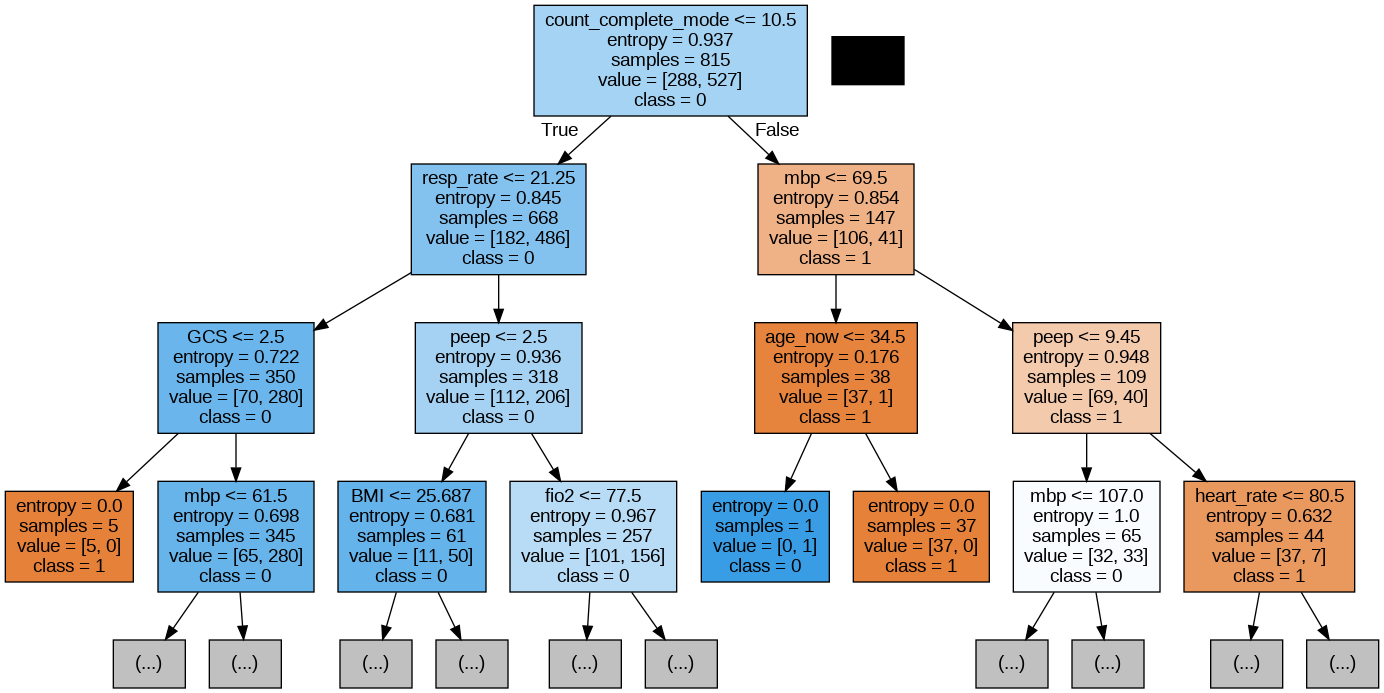

In [9]:
# step4 decision tree

#print("before weaning hour =", print_before_weaning_hr)

# GridSearchCV
from sklearn.model_selection import GridSearchCV

"""
Model = DecisionTreeClassifier()
param_grid = {'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(1, 20), 'min_samples_split':np.arange(2, 8), 'min_samples_leaf':np.arange(1, 5), 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='roc_auc', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
decisionTreeModel = grid_search.best_estimator_
"""

#"""
# 使用訓練資料訓練模型
decisionTreeModel = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=1, min_samples_split=5, random_state=42)
decisionTreeModel = decisionTreeModel.fit(tr_v_X, tr_v_y)
#"""

"""
# accuracy for tr&v
print("train & v")
acc_function(decisionTreeModel, tr_v_X, tr_v_y)
"""
# accuracy for test
print("test")
acc_function(decisionTreeModel, test_X, test_y)

io = StringIO()
tree.export_graphviz(decisionTreeModel, feature_names=(X.drop(['stay_id'], axis=1)).columns, max_depth=3, out_file=io, class_names=np.array(train_y.unique()).astype('str').tolist(), filled=True)
graph_tree = pydotplus.graph_from_dot_data(io.getvalue())
graph_tree.write_png("decision tree")
img_tree = mpl_image.imread("decision tree")
#plt.figure(figsize=(200, 450))
#plt.show(img_tree)
Image(graph_tree.create_png())



In [ ]:
# csv
import csv
csvfile_dt = open('dt_for_roc.csv', 'w', newline='')
writer = csv.writer(csvfile_dt)
writer.writerow(decisionTreeModel.predict_proba(test_X)[:, 1])
csvfile_dt.close()

using (train and validation) to compute feature_importance


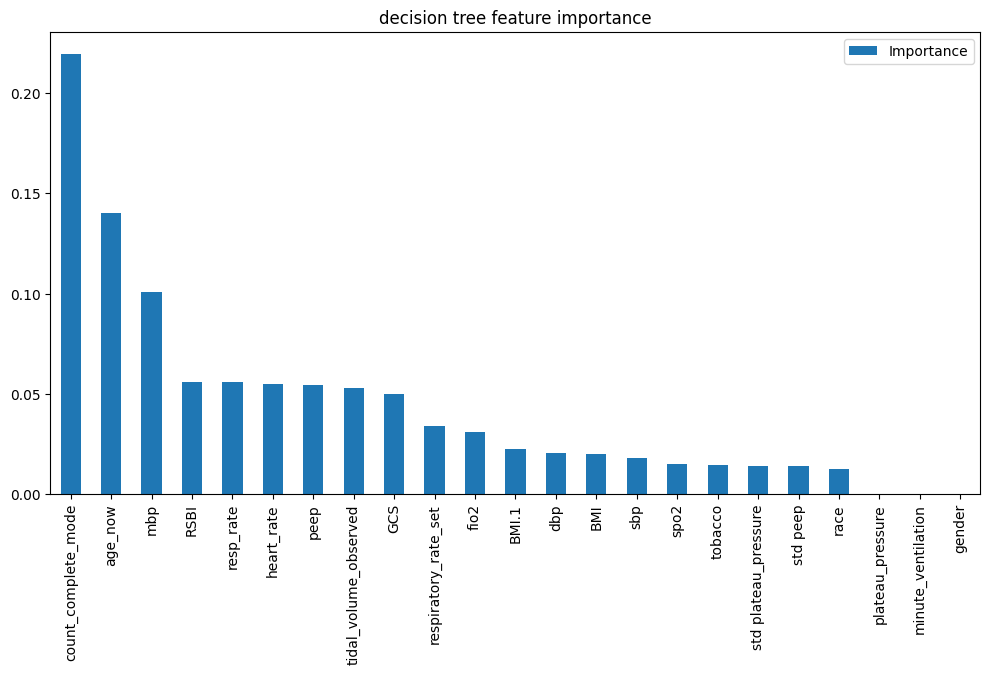

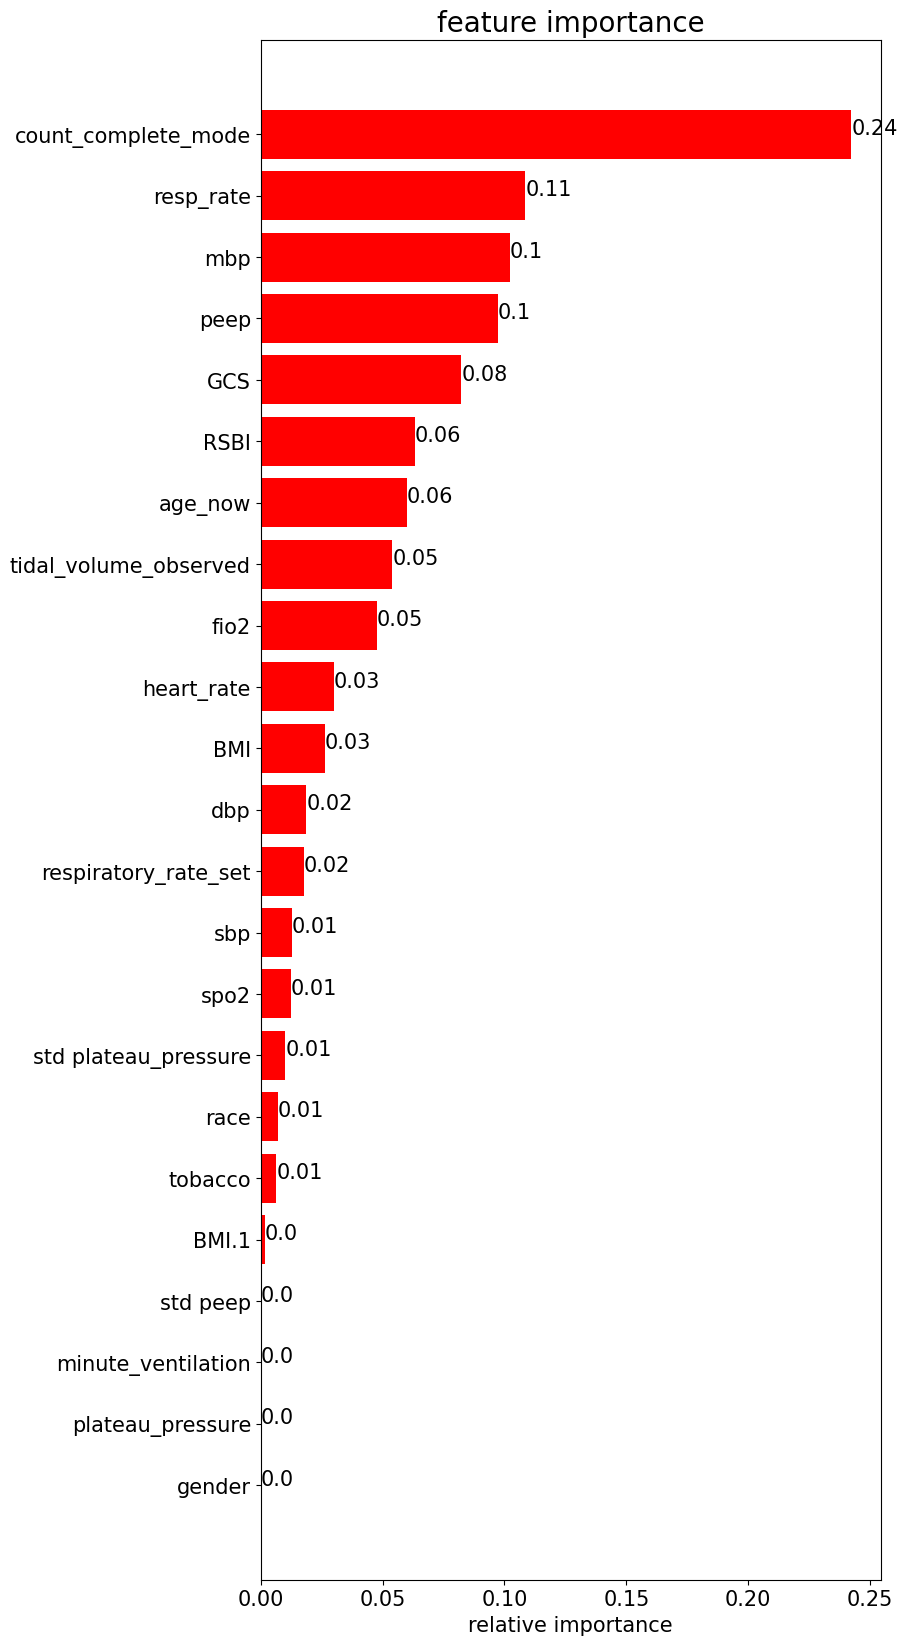

using test to compute feature_importance


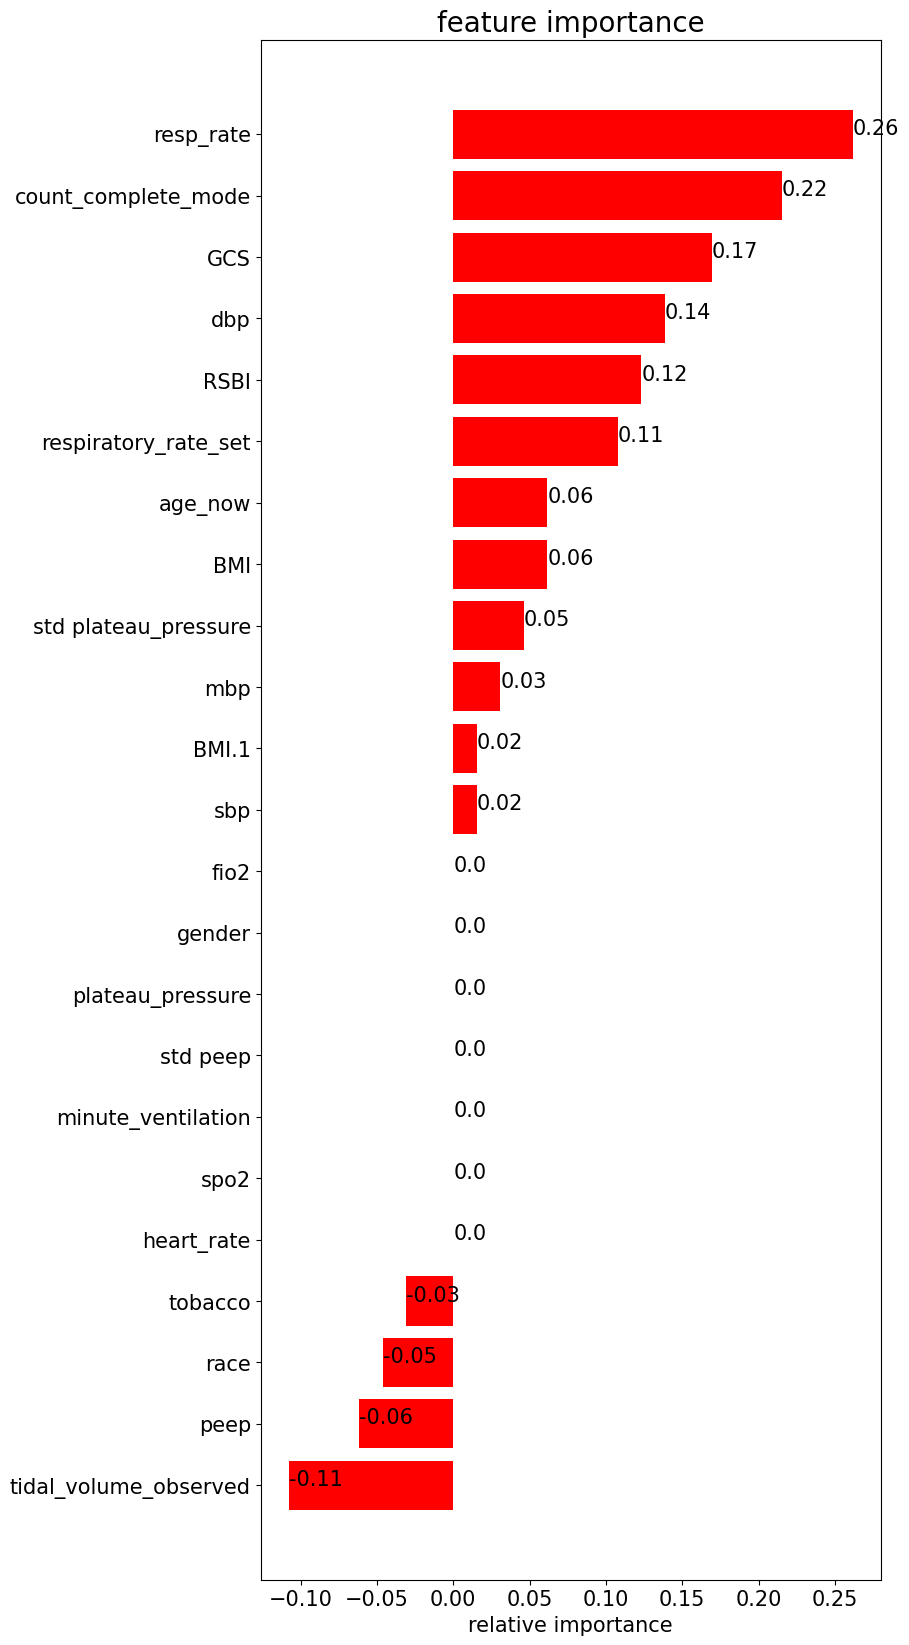

In [10]:
# step 4.1
# decision tree feature importance
dt_importance = decisionTreeModel.feature_importances_
# plot importance
df_dt_importance = pd.DataFrame(dt_importance, index=tr_v_X.columns, columns=['Importance'])
df_dt_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_dt_importance = df_dt_importance[:30]
df_dt_importance.plot(kind='bar', figsize=(12, 6))
plt.title('decision tree feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(decisionTreeModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(decisionTreeModel, test_X, test_y)

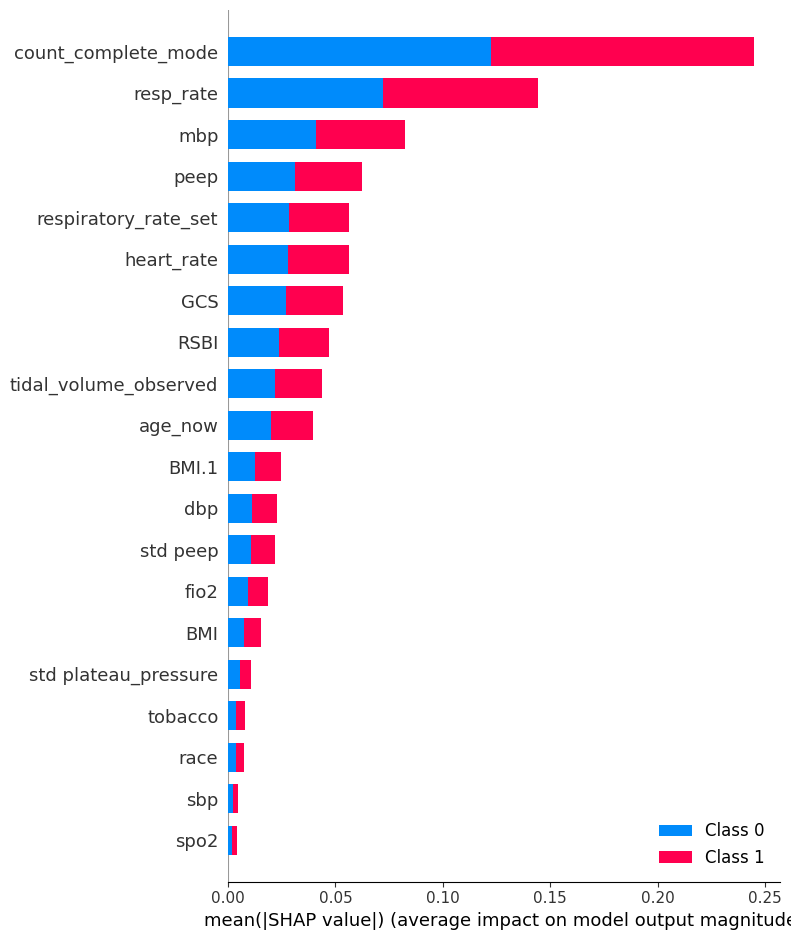

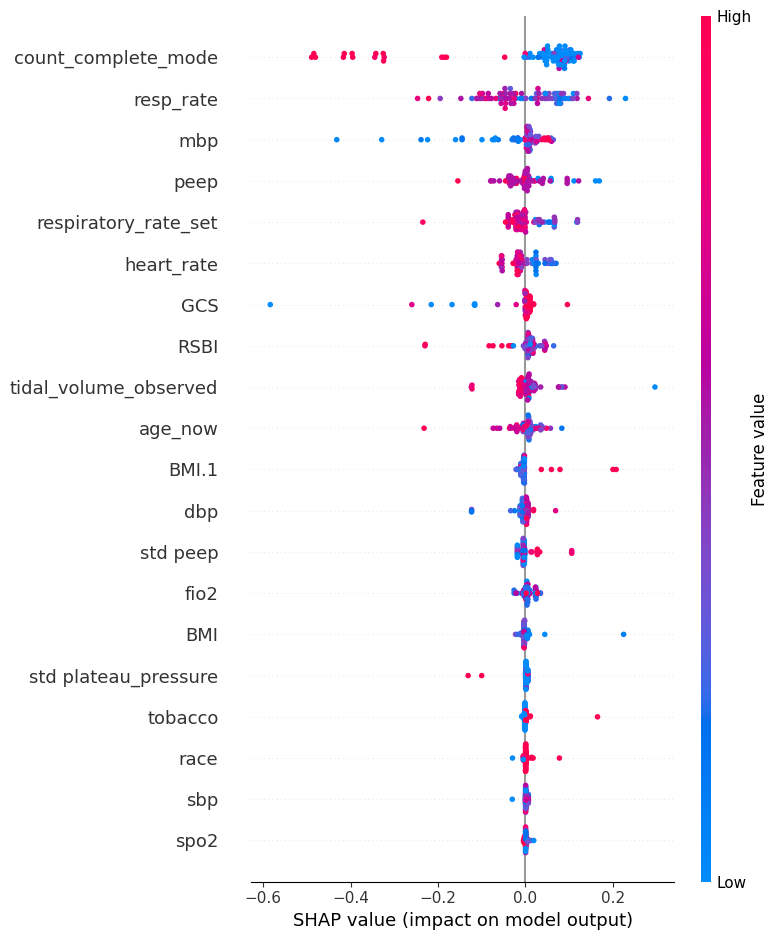

In [18]:
#explainer = shap.KernelExplainer(model=svmModel.predict_proba, data=train_X[:50], link='logit')
#shap_values = explainer.shap_values(X=test_X, nsamples=100)

#shap.summary_plot(shap_values, test_X, plot_type="bar", class_names= 'label', feature_names = train_X.columns)
#shap.summary_plot(shap_values[1], test_X, feature_names = train_X.columns)

# 決策樹模型的 SHAP Explainer
explainer_dt = shap.TreeExplainer(model=decisionTreeModel)
shap_values_dt = explainer_dt.shap_values(test_X)

# 總結圖
shap.summary_plot(shap_values_dt, test_X, plot_type="bar", feature_names=train_X.columns)
shap.summary_plot(shap_values_dt[1], test_X, feature_names=train_X.columns)

test
sensitivity=recall= 0.9454545454545454
specificity 0.25
confusion_matrix
 [[ 7 21]
 [ 3 52]]
accuracy_score 0.7108433734939759
ROC curve
roc_auc 0.6662337662337663
c_r
              precision    recall  f1-score   support

     class 0       0.70      0.25      0.37        28
     class 1       0.71      0.95      0.81        55

    accuracy                           0.71        83
   macro avg       0.71      0.60      0.59        83
weighted avg       0.71      0.71      0.66        83



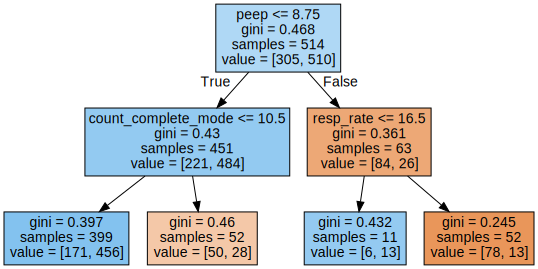

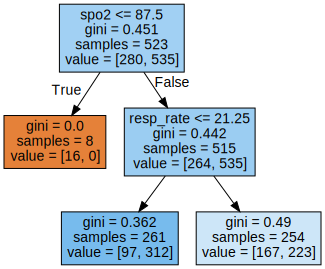

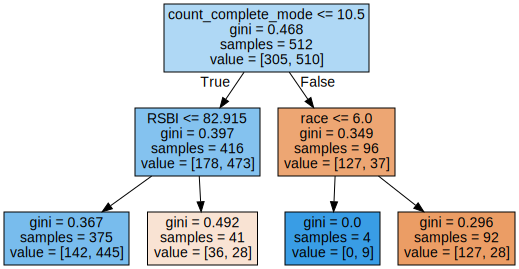

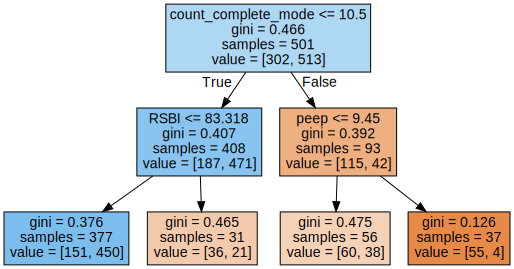

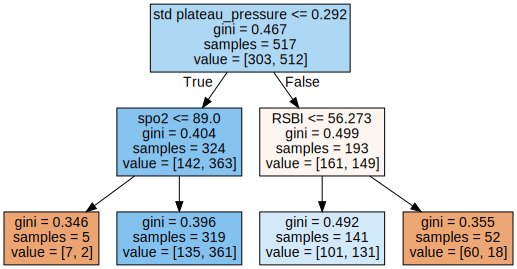

using (train and validation) to compute feature_importance


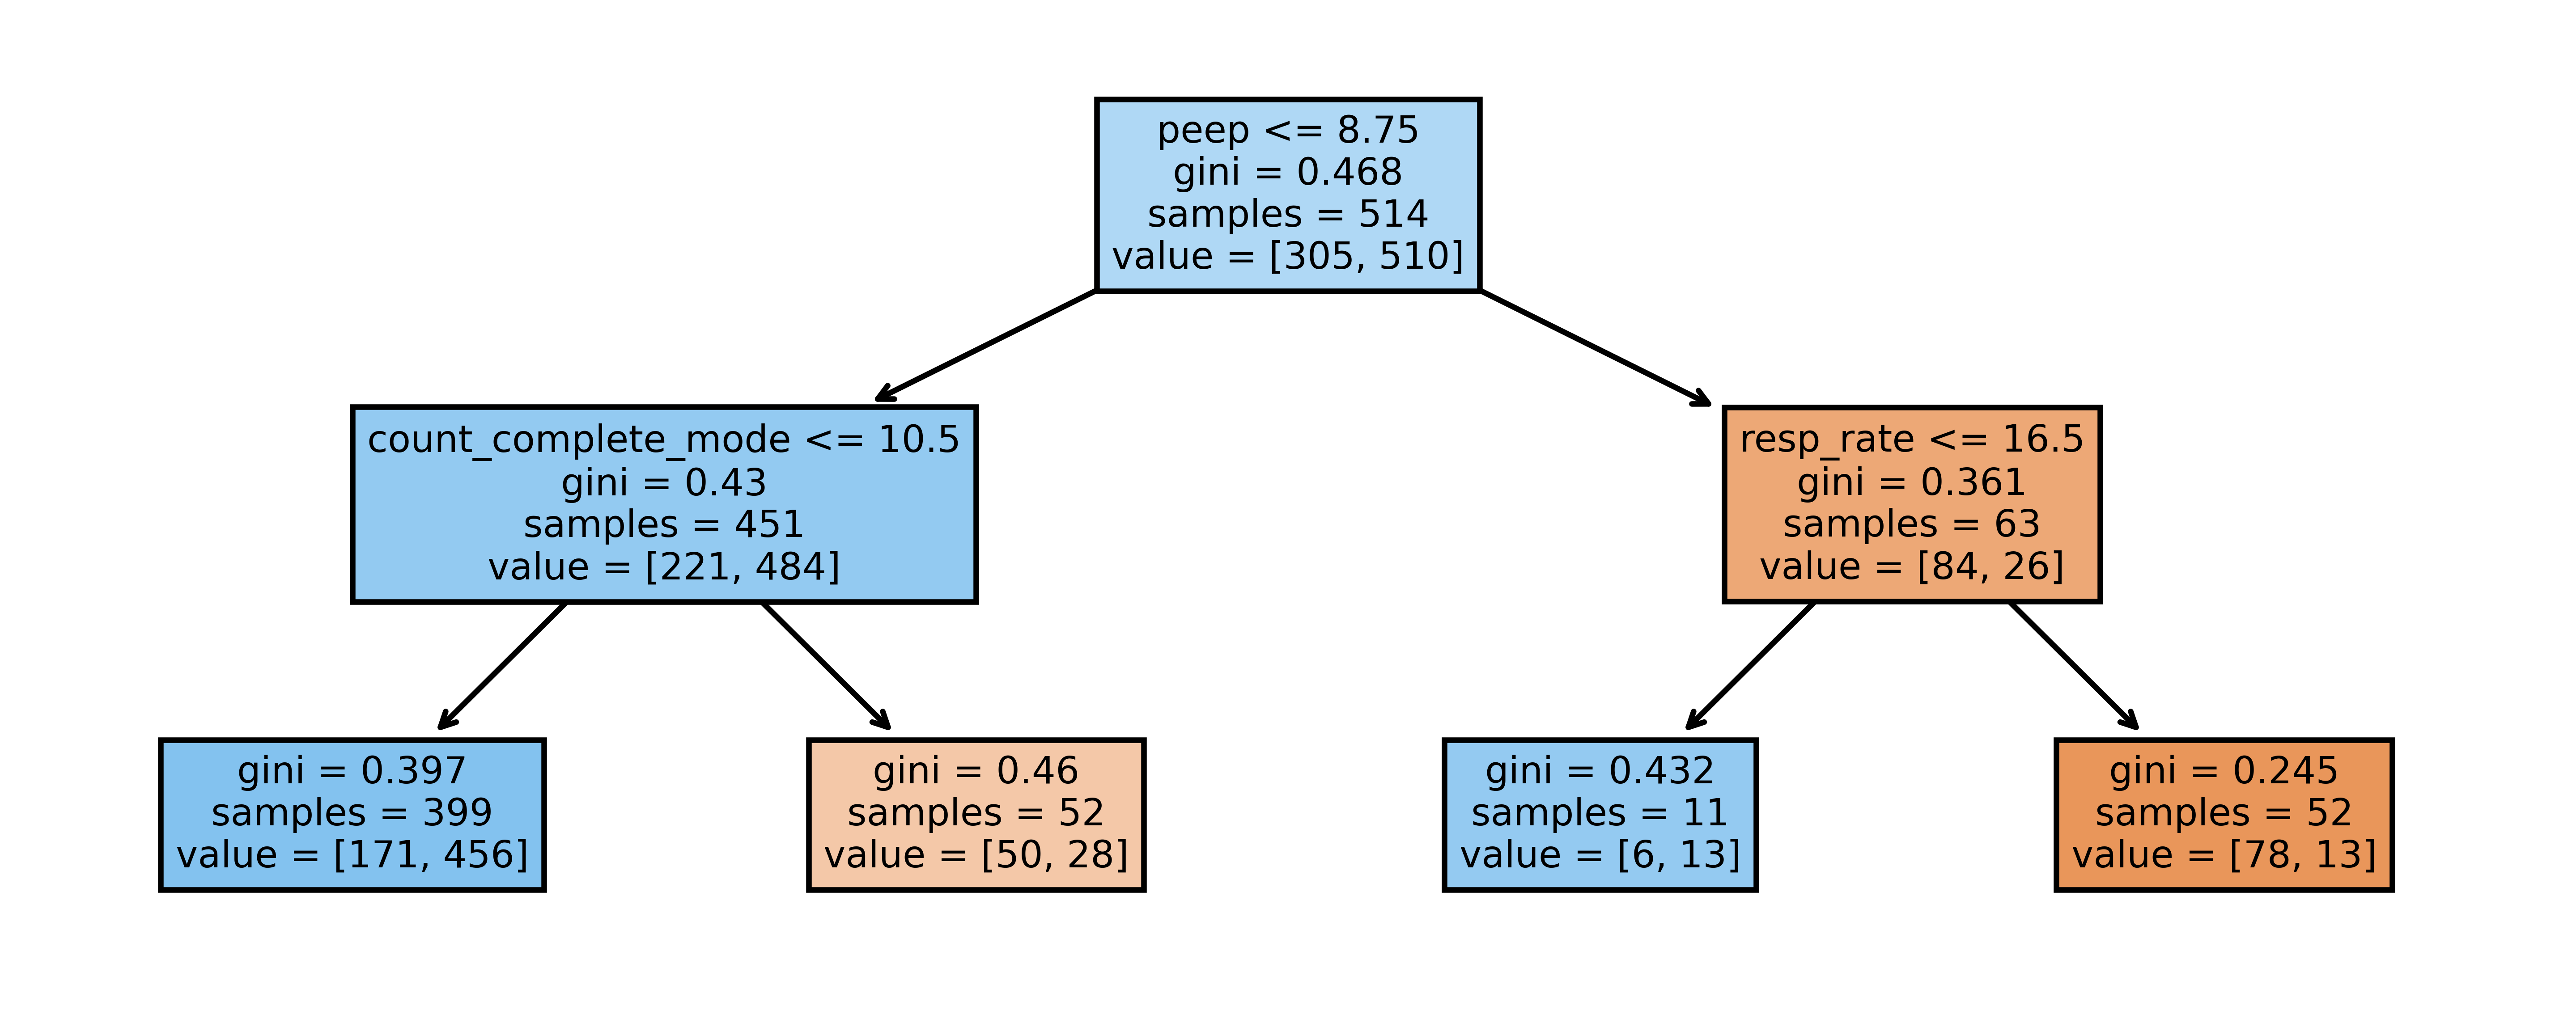

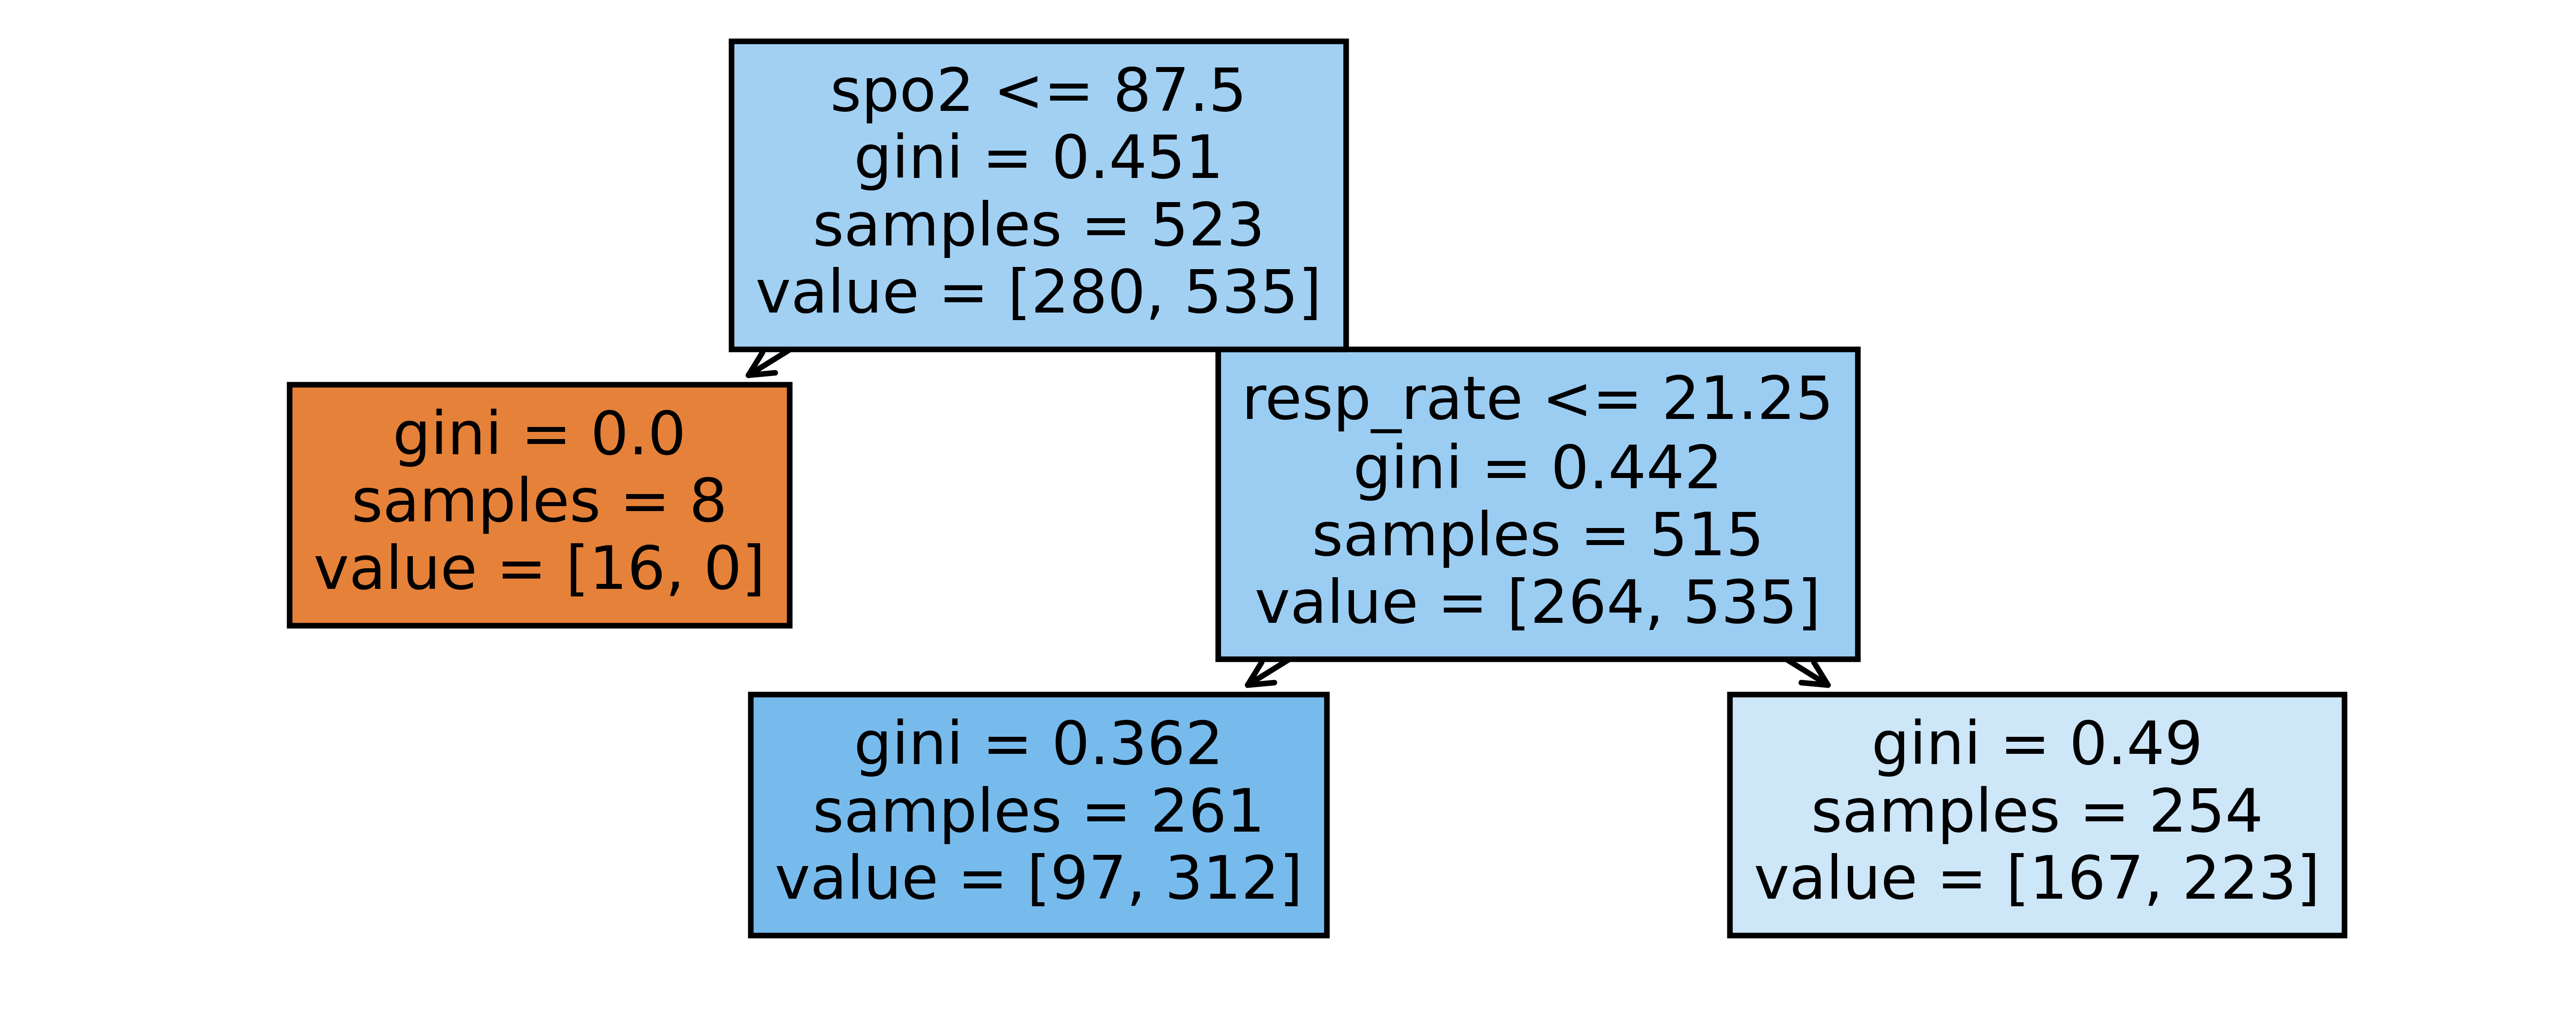

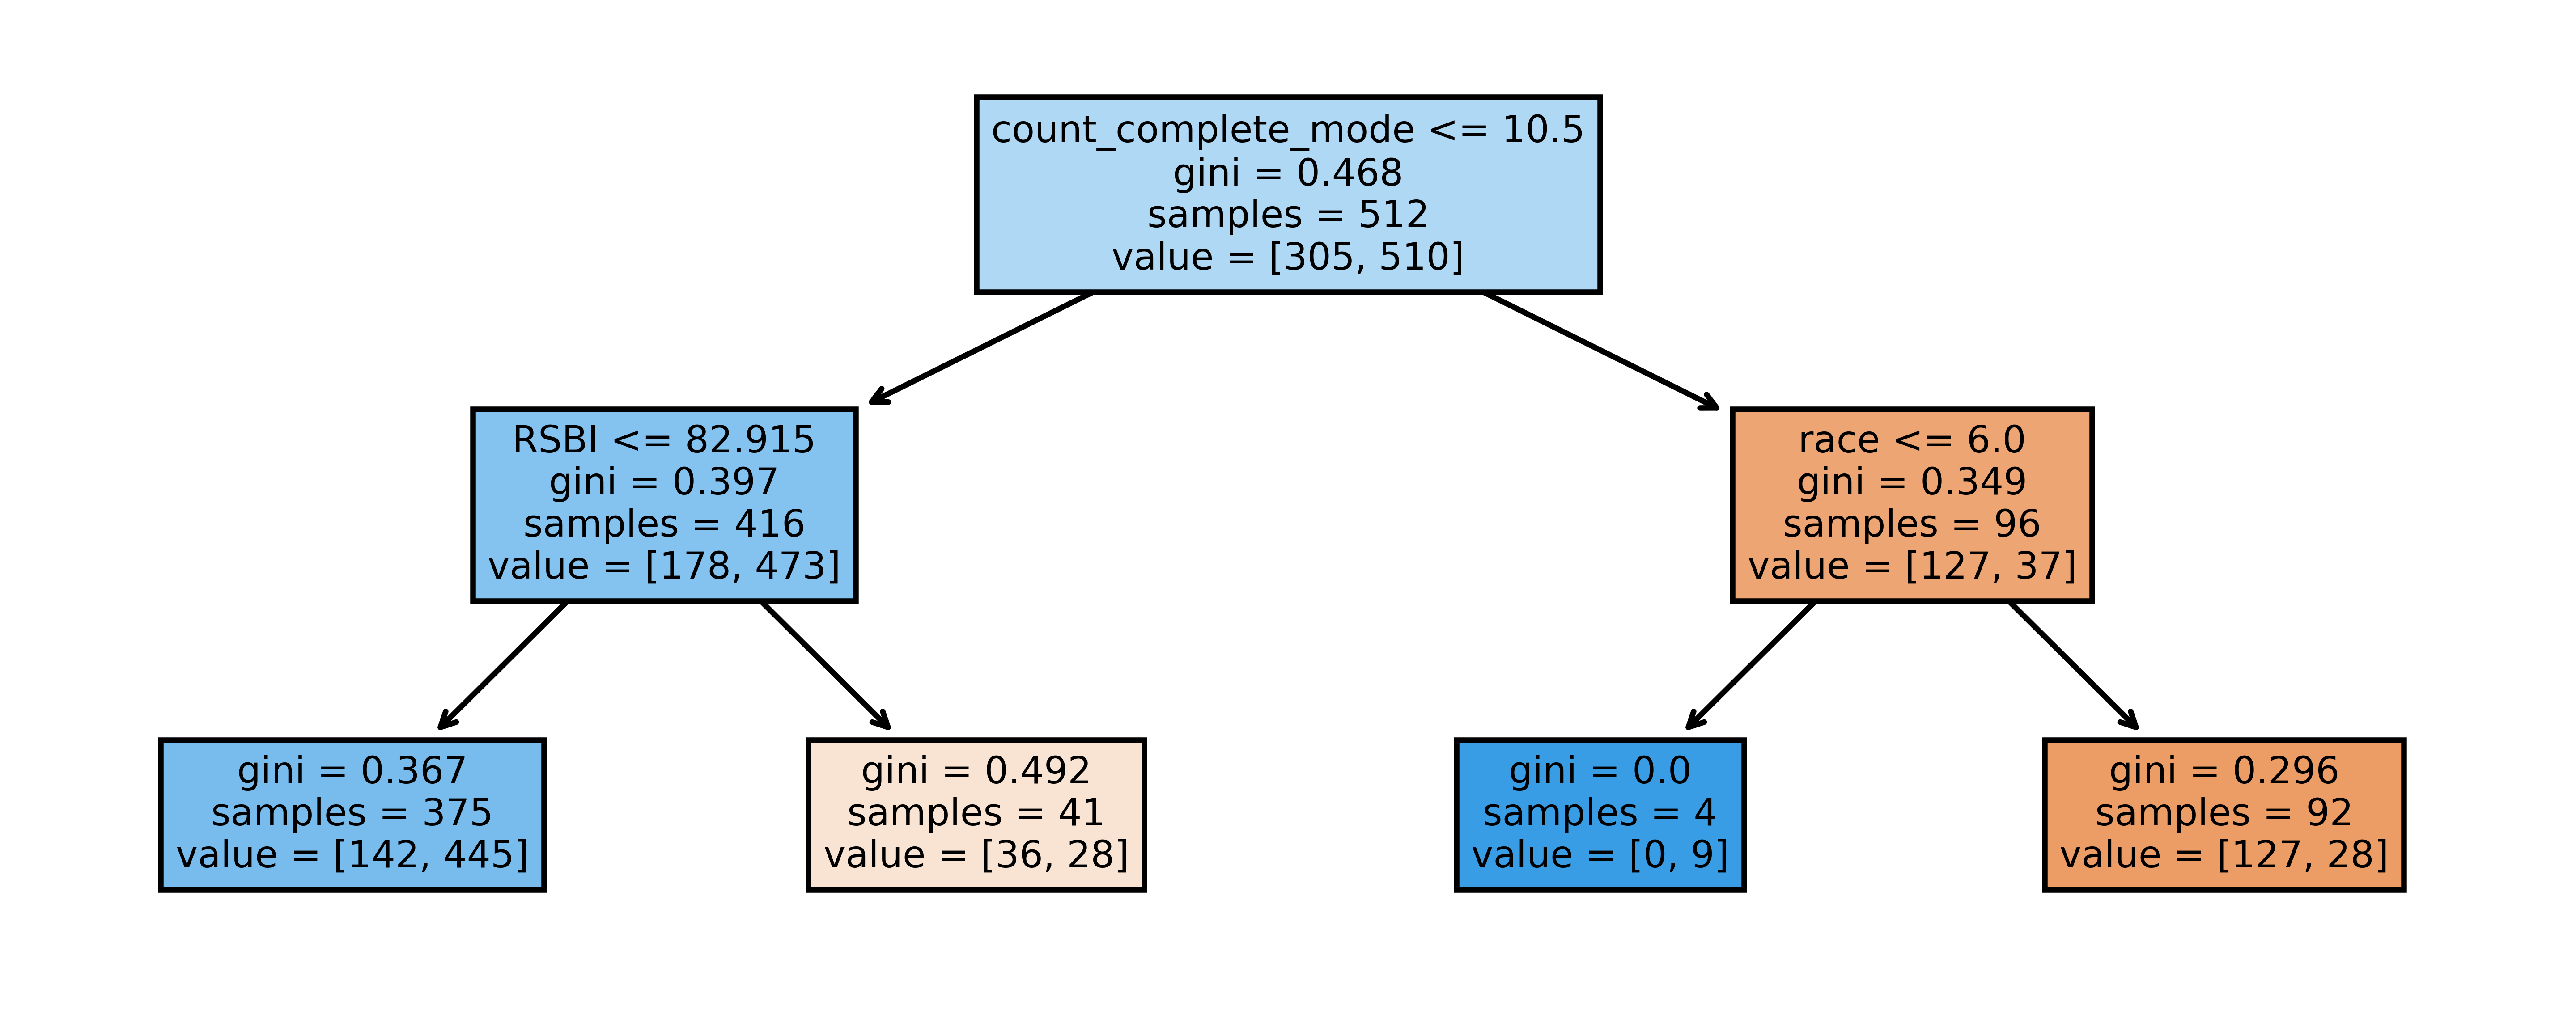

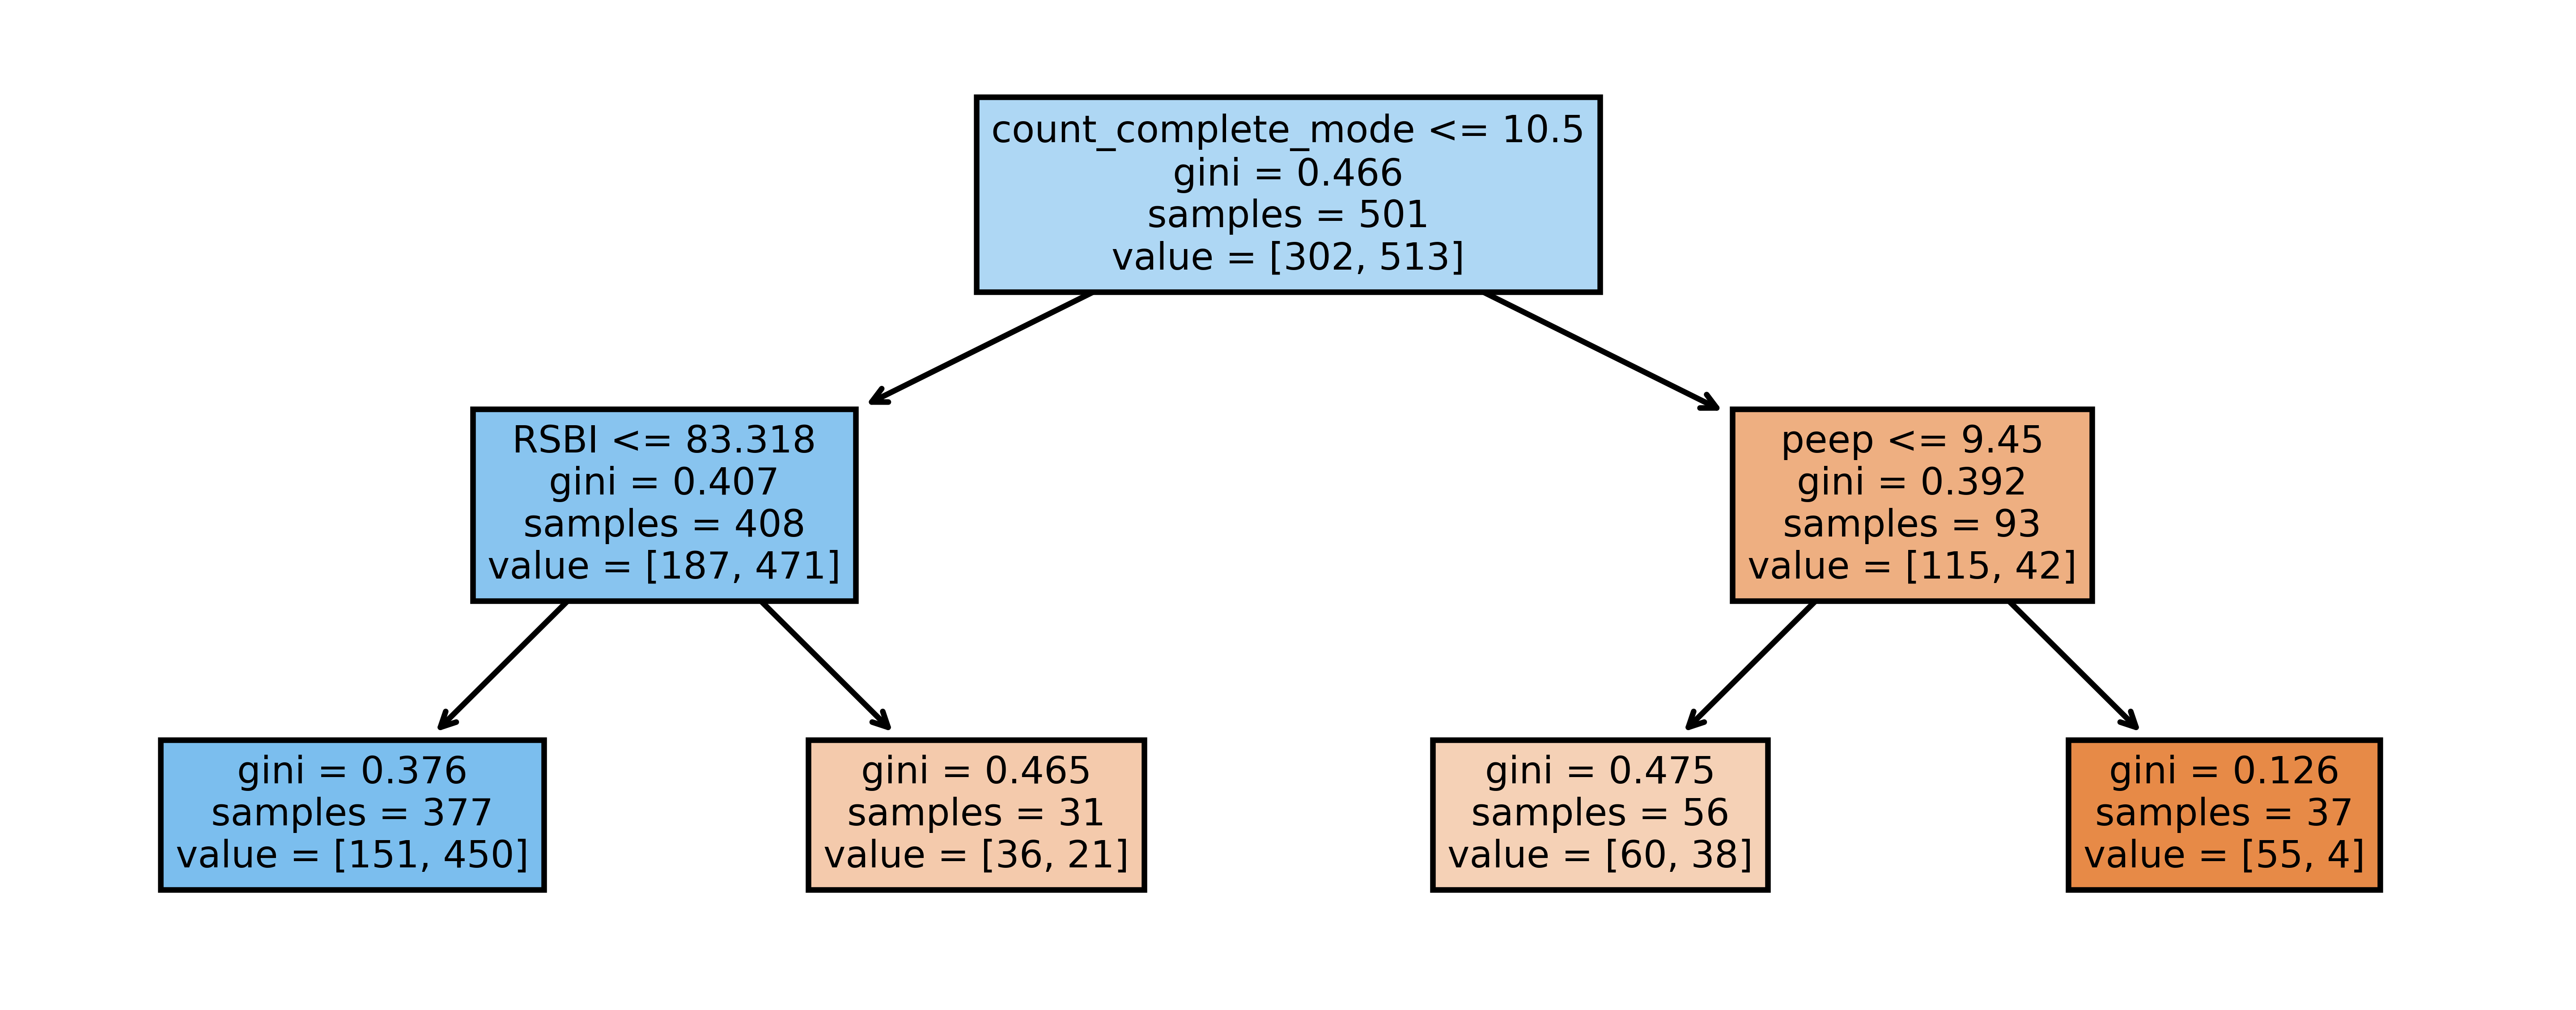

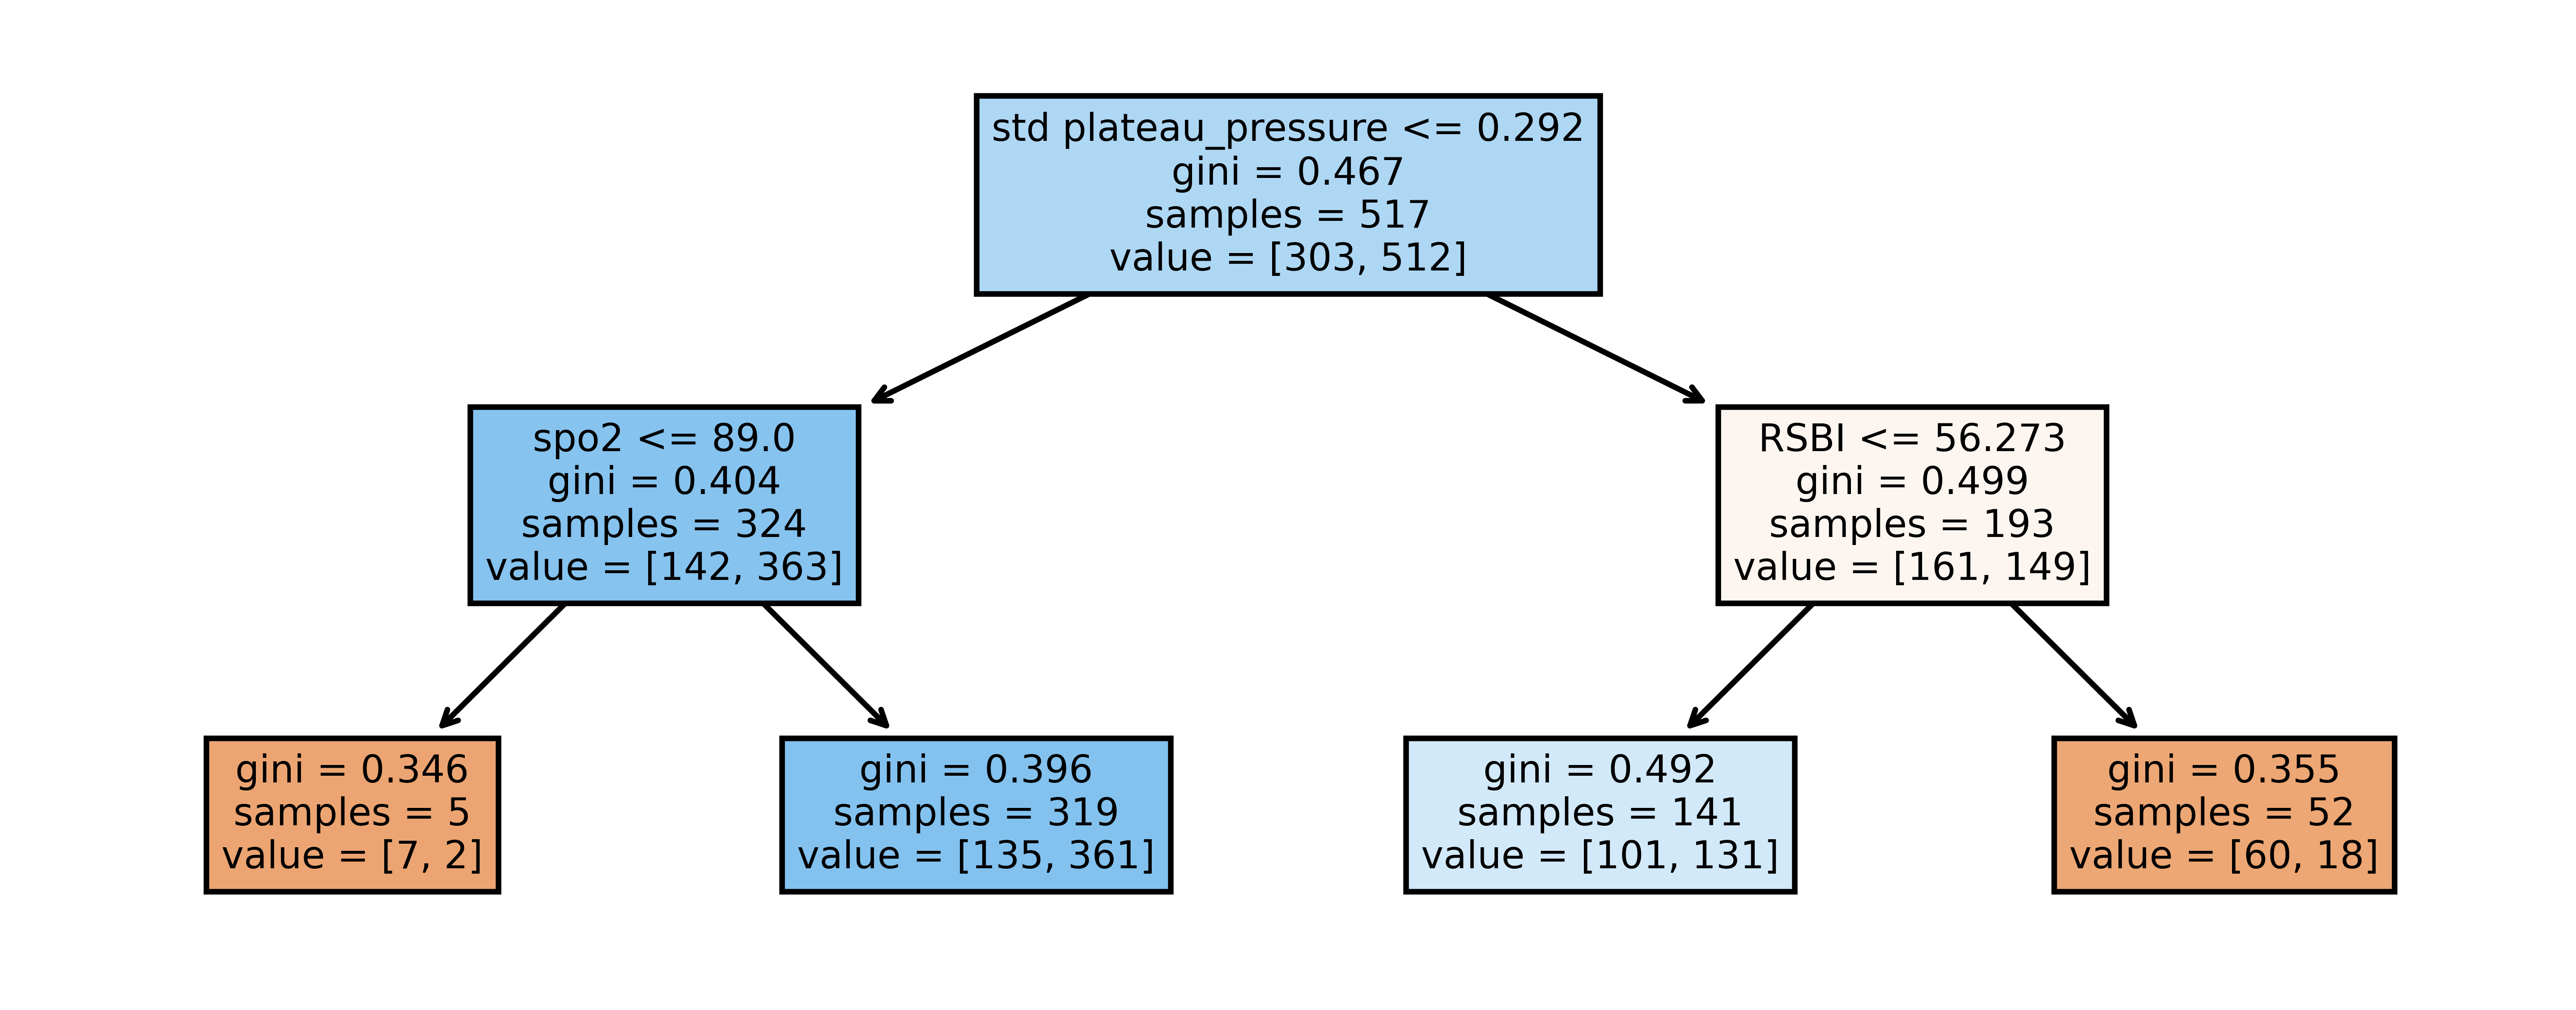

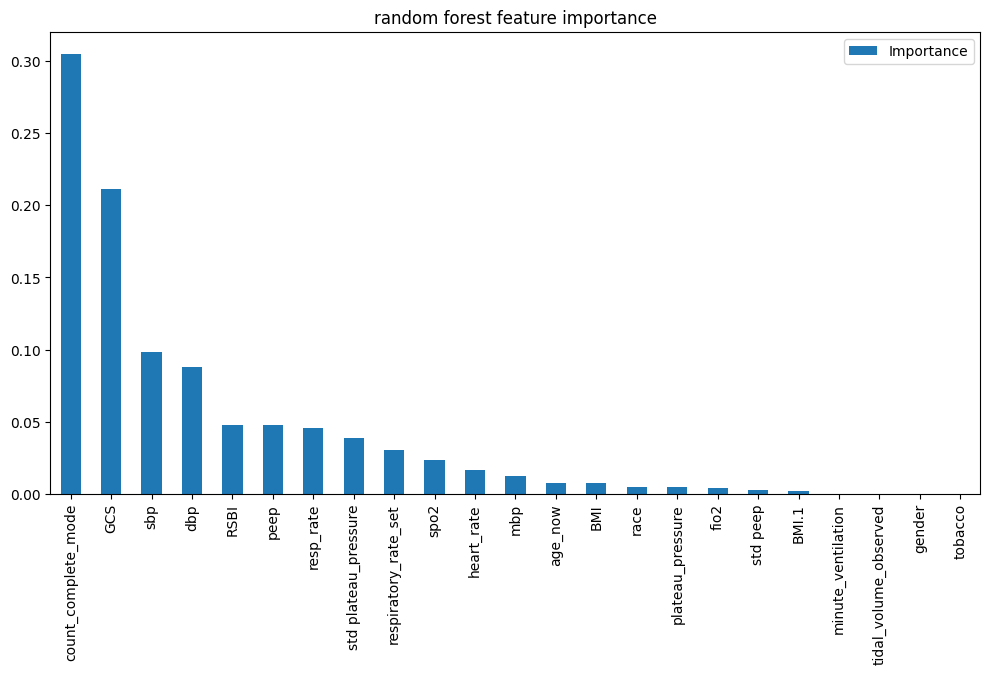

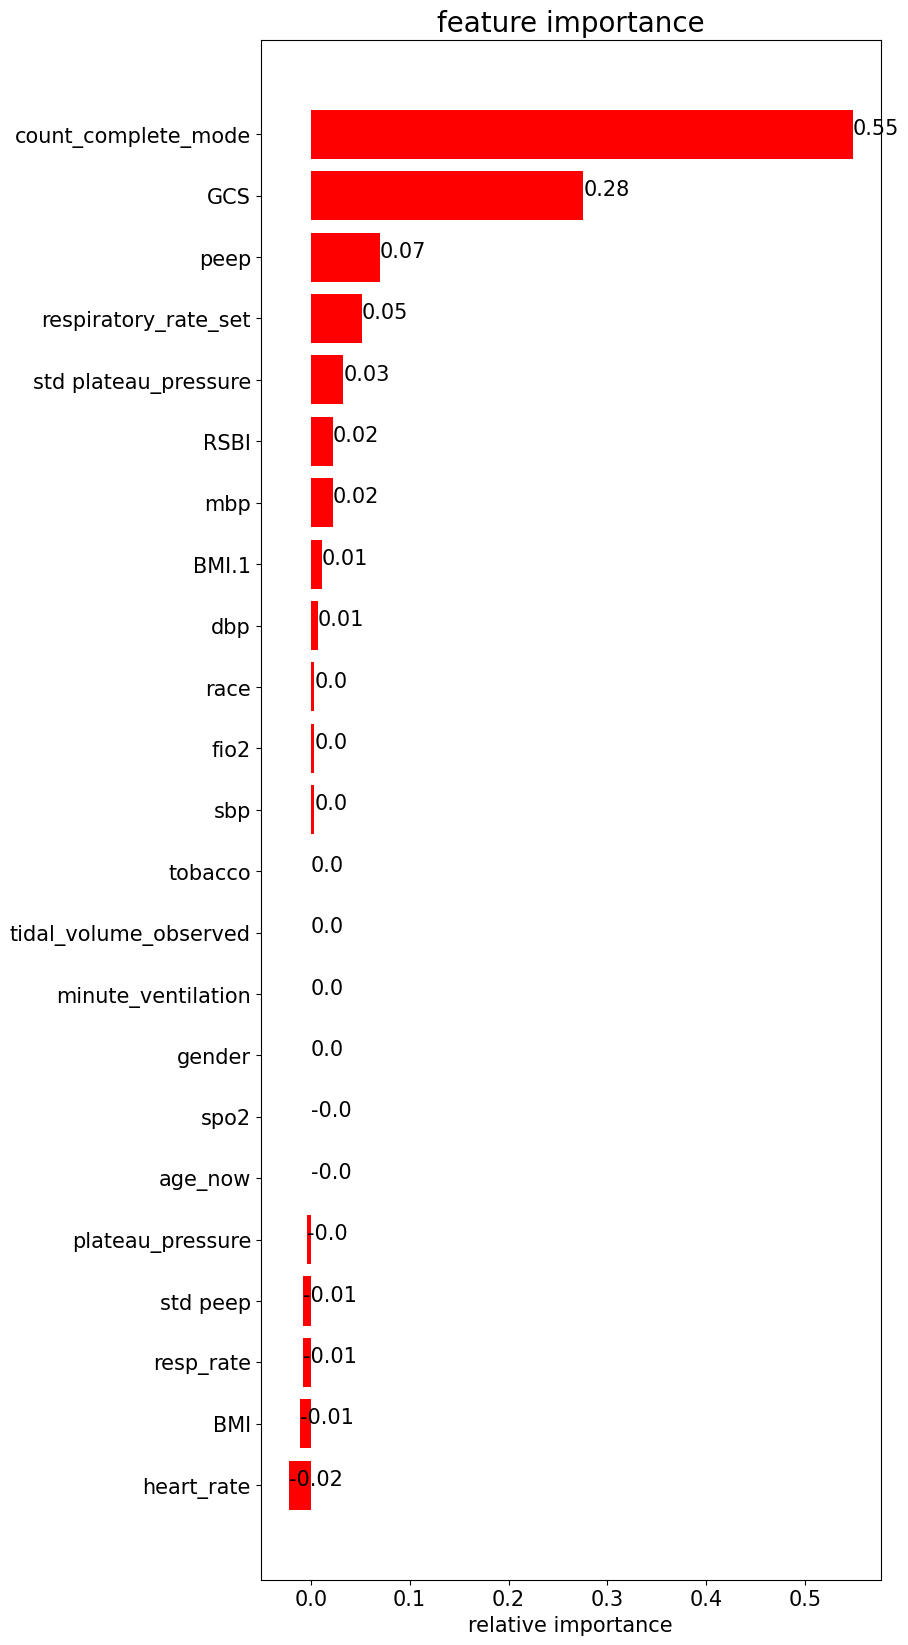

using test to compute feature_importance


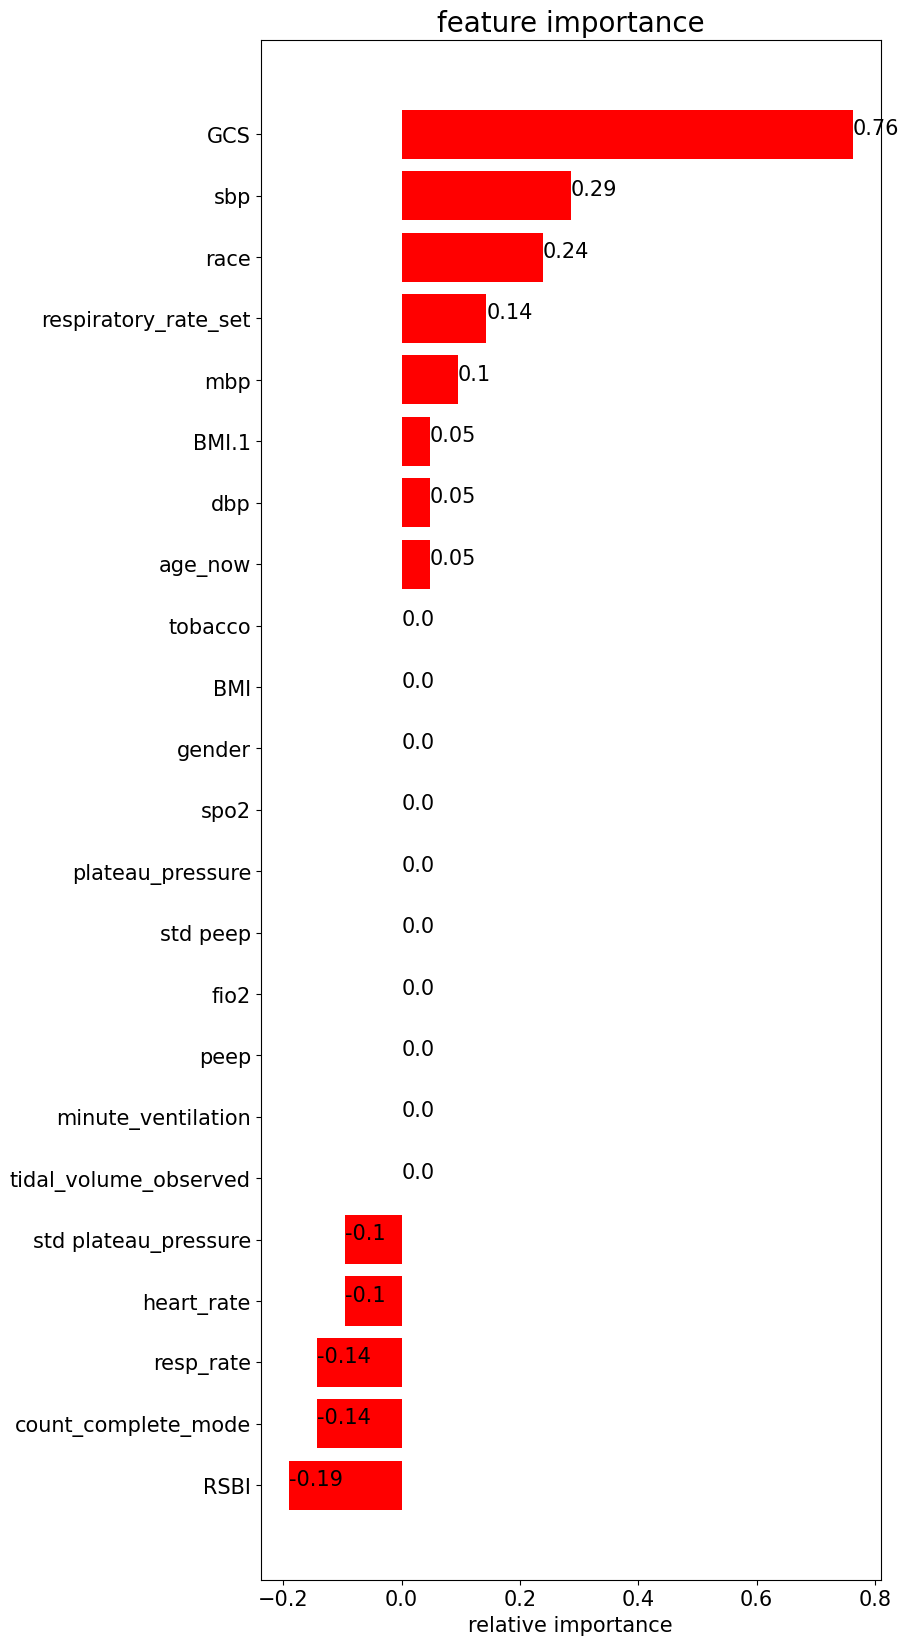

In [19]:
# step4 random forest
from sklearn.ensemble import RandomForestClassifier
tree_num = 5
from sklearn.model_selection import GridSearchCV

"""
Model = RandomForestClassifier()
param_grid = {'n_estimators':np.arange(1, 30), 'criterion':('gini', 'entropy', 'log_loss'), 'max_depth':np.arange(1, 30), 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='roc_auc', error_score='raise')
#grid_search.fit(train_X, train_y)
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
randomforestModel = grid_search.best_estimator_
"""

#"""
# 使用訓練資料訓練模型
randomforestModel = RandomForestClassifier(criterion='gini', max_depth=2, n_estimators=26, random_state=42)
randomforestModel.fit(tr_v_X, tr_v_y)
#"""

# 使用訓練資料預測

#print("before weaning hour =", print_before_weaning_hr)


# 使用訓練資料預測
"""
# accuracy for tr&v
print("train & v")
acc_function(randomforestModel, tr_v_X, tr_v_y)
"""
# accuracy for test
print("test")
acc_function(randomforestModel, test_X, test_y)


# draw tree in forest
#io = StringIO()
#fig, axes = plt.subplots(nrows=tree_num, ncols=3, figsize=(10, 2), dpi=900)
for i in range(tree_num):
    tree_of_rf = randomforestModel.estimators_[i]
    data = export_graphviz(tree_of_rf, feature_names=train_X.columns, max_depth=3, filled=True)
    graph = graphviz.Source(data)
    display(graph)
    figtmp, axestmp = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), dpi=900)
    tree.plot_tree(tree_of_rf, feature_names=train_X.columns, max_depth=3, filled=True)
    #figtmp.set_title('Estimator: '+str(i))#, fontsize=8)
    figtmp.savefig('rf_tmp'+str(i)+'.jpg')


# feature importance
rf_importance = randomforestModel.feature_importances_
# plot importance
df_rf_importance = pd.DataFrame(rf_importance, index=tr_v_X.columns, columns=['Importance'])
df_rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_rf_importance = df_rf_importance[:30]
df_rf_importance.plot(kind='bar', figsize=(12, 6))
plt.title('random forest feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(randomforestModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(randomforestModel, test_X, test_y)

# csv
import csv
csvfile_rf = open('rf_for_roc.csv', 'w', newline='')
writer = csv.writer(csvfile_rf)
writer.writerow(randomforestModel.predict_proba(test_X)[:, 1])
csvfile_rf.close()

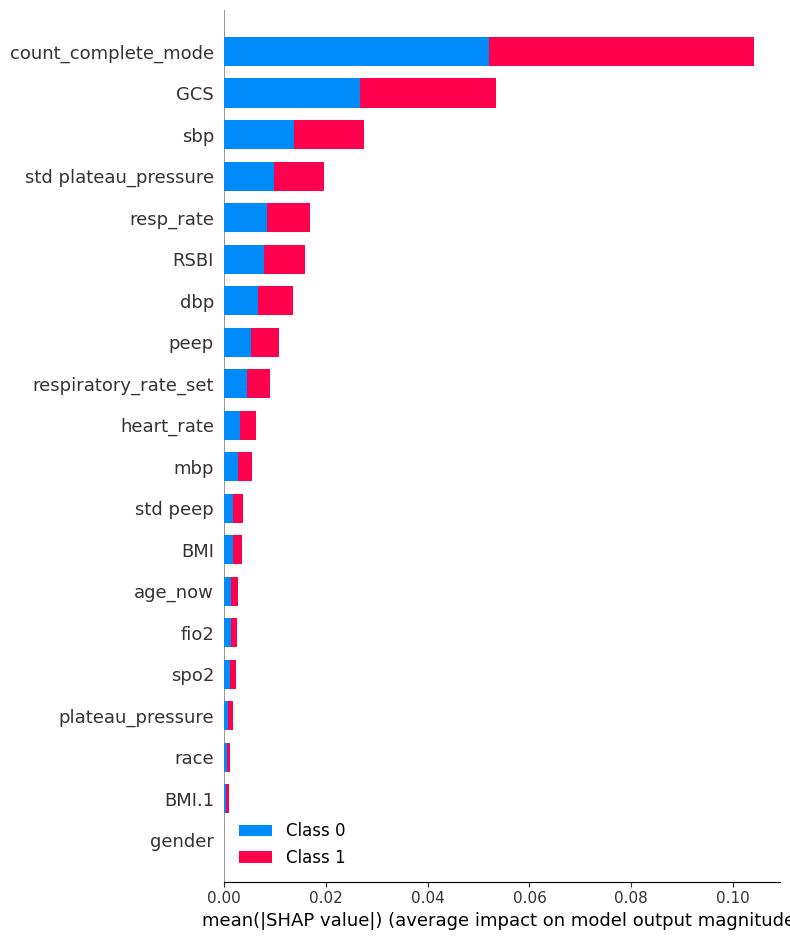

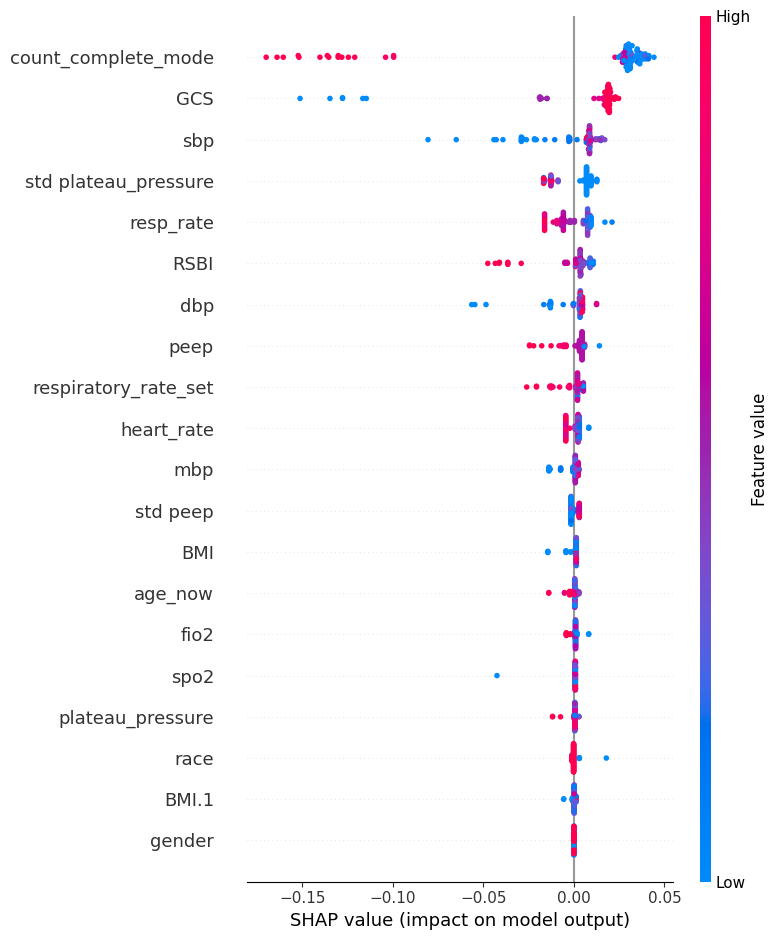

In [20]:
# 隨機森林模型的 SHAP Explainer
explainer_rf = shap.TreeExplainer(model=randomforestModel)
shap_values_rf = explainer_rf.shap_values(test_X)

# 總結圖
shap.summary_plot(shap_values_rf, test_X, plot_type="bar", feature_names=train_X.columns)
shap.summary_plot(shap_values_rf[1], test_X, feature_names=train_X.columns)

train & v
sensitivity=recall= 0.9658444022770398
specificity 0.34375
confusion_matrix
 [[ 99 189]
 [ 18 509]]
accuracy_score 0.7460122699386503
ROC curve
roc_auc 0.761273192072528
c_r
              precision    recall  f1-score   support

     class 0       0.85      0.34      0.49       288
     class 1       0.73      0.97      0.83       527

    accuracy                           0.75       815
   macro avg       0.79      0.65      0.66       815
weighted avg       0.77      0.75      0.71       815

test
sensitivity=recall= 0.9454545454545454
specificity 0.25
confusion_matrix
 [[ 7 21]
 [ 3 52]]
accuracy_score 0.7108433734939759
ROC curve
roc_auc 0.7746753246753246
c_r
              precision    recall  f1-score   support

     class 0       0.70      0.25      0.37        28
     class 1       0.71      0.95      0.81        55

    accuracy                           0.71        83
   macro avg       0.71      0.60      0.59        83
weighted avg       0.71      0.71      0.66 

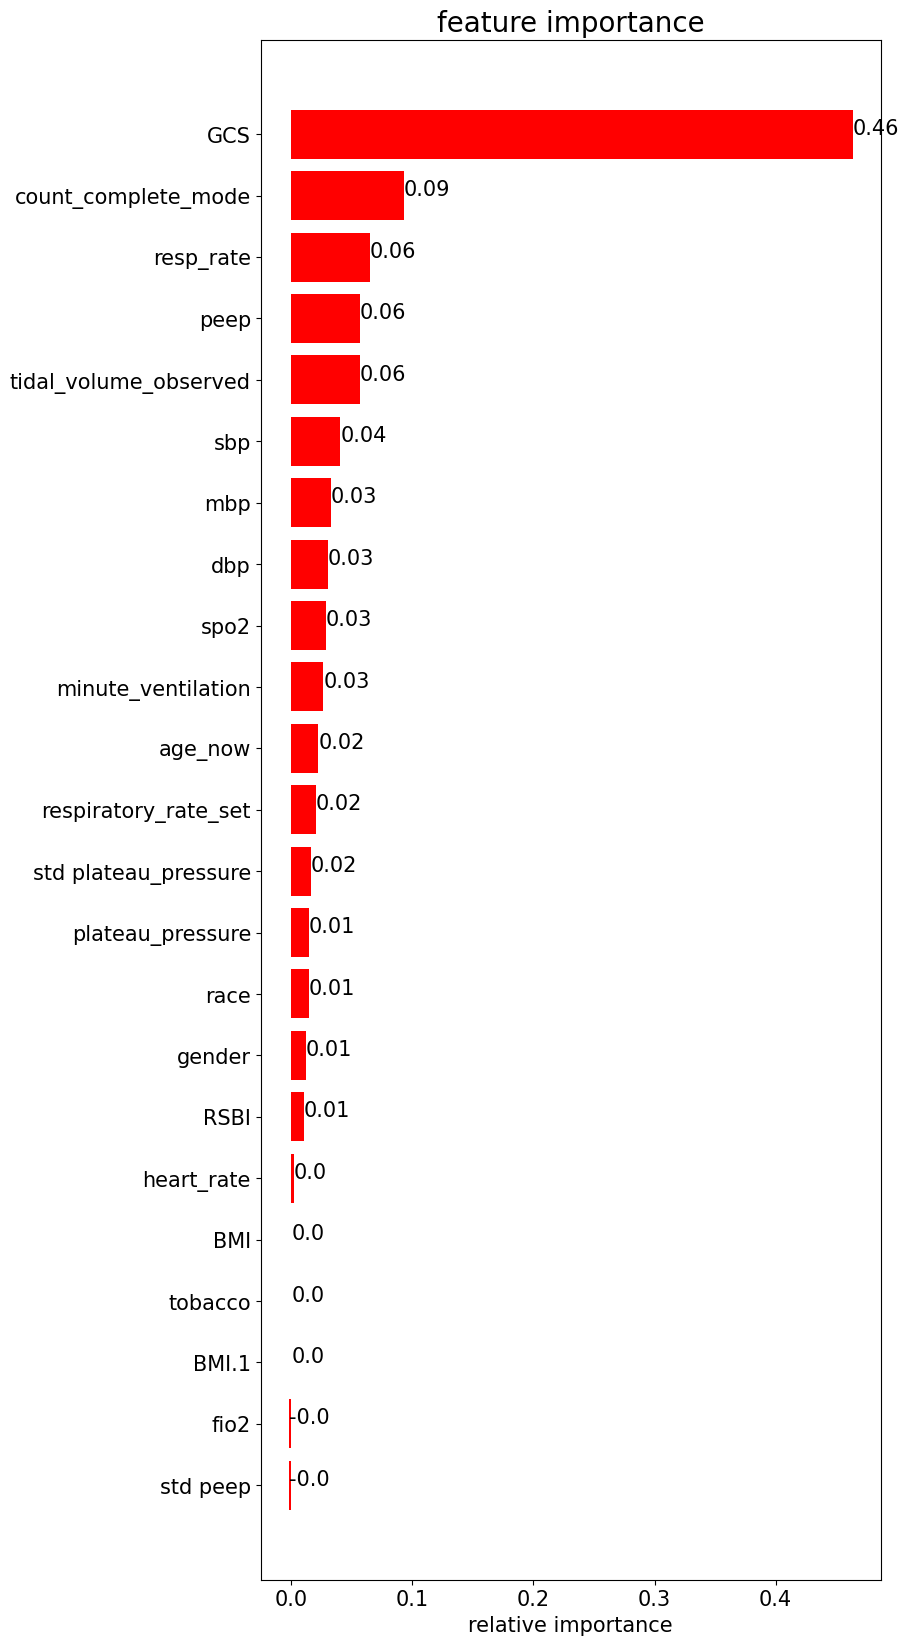

using test to compute feature_importance


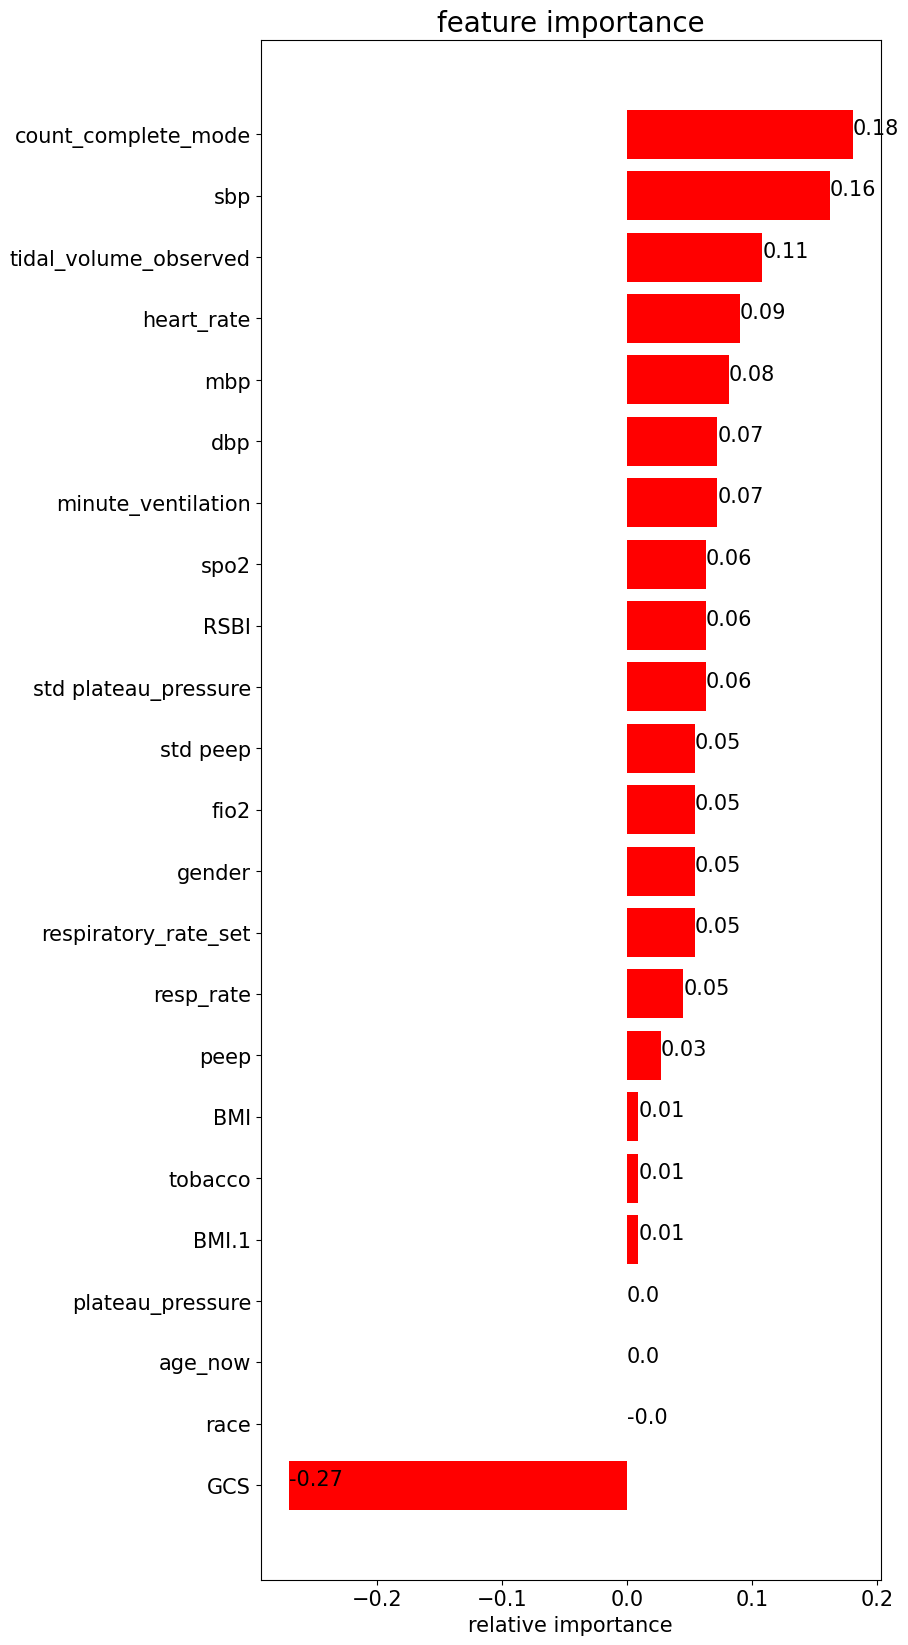

In [21]:
# step4 SVM

# param_grid = {'C':np.linspace(1, 3, 3, endpoint=True), 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'random_state':[42]} ->get {C=2, 'kernel'='linear'}
#print("before weaning hour =",print_before_weaning_hr)

from sklearn.svm import SVC

# SVM with all features
from sklearn.model_selection import GridSearchCV
"""
Model = SVC() #(C=1, kernel=linear, probability=True, random_state=42)
param_grid = {'C':np.linspace(1, 3, 3, endpoint=True), 'kernel':('linear', 'poly'),'probability':[True], 'random_state':[42]} #, 'rbf', 'sigmoid'
#param_grid = {'C':[1], 'kernel':['linear'],'probability':[True], 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='roc_auc', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
svmModel = grid_search.best_estimator_
"""
#c=1, accuracy_score 0.7420249653259362

#"""
svmModel = SVC(C=1, kernel='linear', probability=True, random_state=42)
svmModel.fit(tr_v_X, tr_v_y)
#"""

# accuracy for tr&v
print("train & v")
acc_function(svmModel, tr_v_X, tr_v_y)

# accuracy for test
print("test")
acc_function(svmModel, test_X, test_y)

print('using (train and validation) to compute feature_importance')
feature_importance(svmModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(svmModel, test_X, test_y)

# csv
import csv
csvfile_svm = open('svm_for_roc.csv', 'w', newline='')
writer = csv.writer(csvfile_svm)
writer.writerow(svmModel.predict_proba(test_X)[:, 1])
csvfile_svm.close()

  0%|          | 0/83 [00:00<?, ?it/s]

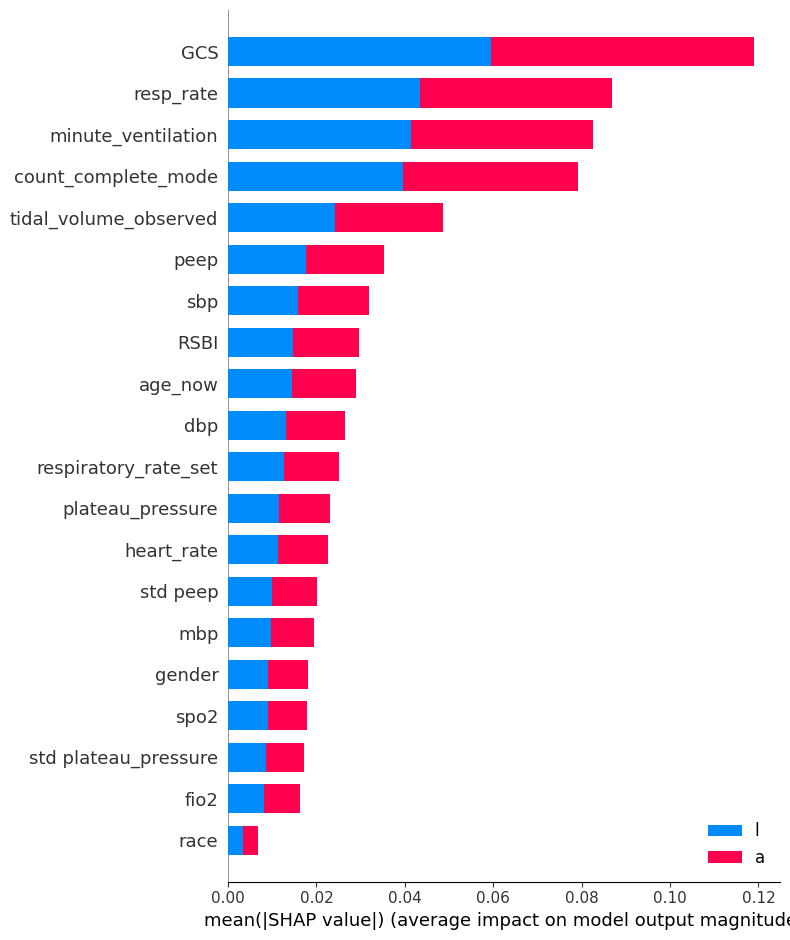

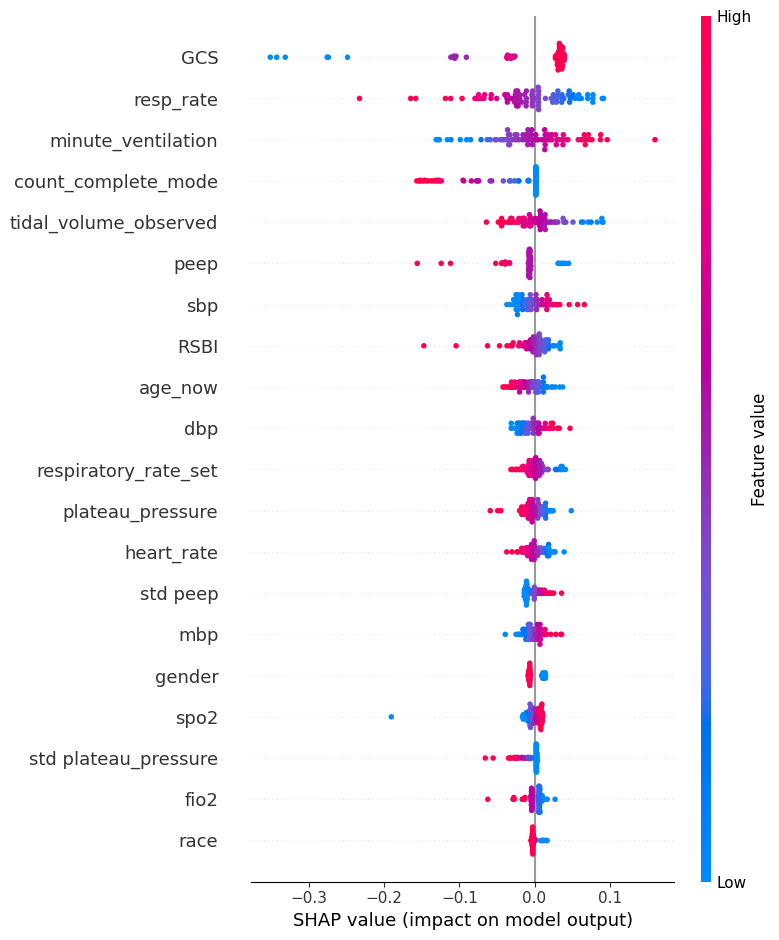

In [43]:
#SHAP_SVM

#explainer = shap.KernelExplainer(model=svmModel.predict_proba, data=train_X[:50], link='logit')
explainer = shap.KernelExplainer(model=svmModel.predict_proba, data=train_X[:50])
shap_values = explainer.shap_values(X=test_X)

shap.summary_plot(shap_values, test_X, plot_type="bar", class_names= 'label', feature_names = train_X.columns)
shap.summary_plot(shap_values[1], test_X, feature_names = train_X.columns)

train & v
sensitivity=recall= 0.9582542694497154
specificity 0.3715277777777778
confusion_matrix
 [[107 181]
 [ 22 505]]
accuracy_score 0.750920245398773
ROC curve
roc_auc 0.7721708306978706
c_r
              precision    recall  f1-score   support

     class 0       0.83      0.37      0.51       288
     class 1       0.74      0.96      0.83       527

    accuracy                           0.75       815
   macro avg       0.78      0.66      0.67       815
weighted avg       0.77      0.75      0.72       815

test
sensitivity=recall= 0.9090909090909091
specificity 0.2857142857142857
confusion_matrix
 [[ 8 20]
 [ 5 50]]
accuracy_score 0.6987951807228916
ROC curve
roc_auc 0.6733766233766234
c_r
              precision    recall  f1-score   support

     class 0       0.62      0.29      0.39        28
     class 1       0.71      0.91      0.80        55

    accuracy                           0.70        83
   macro avg       0.66      0.60      0.60        83
weighted avg       

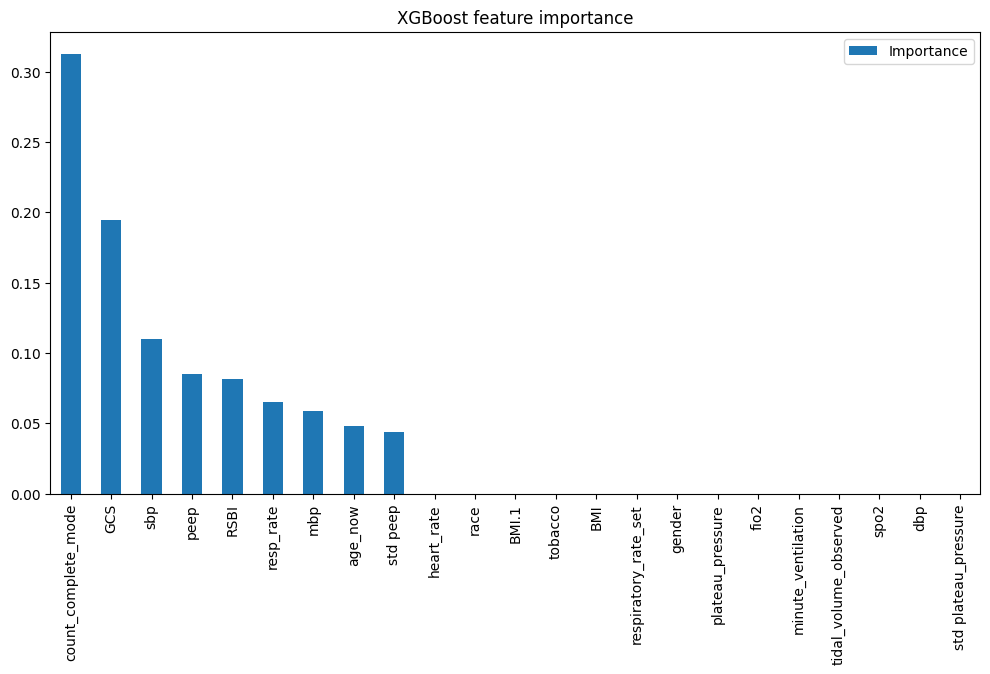

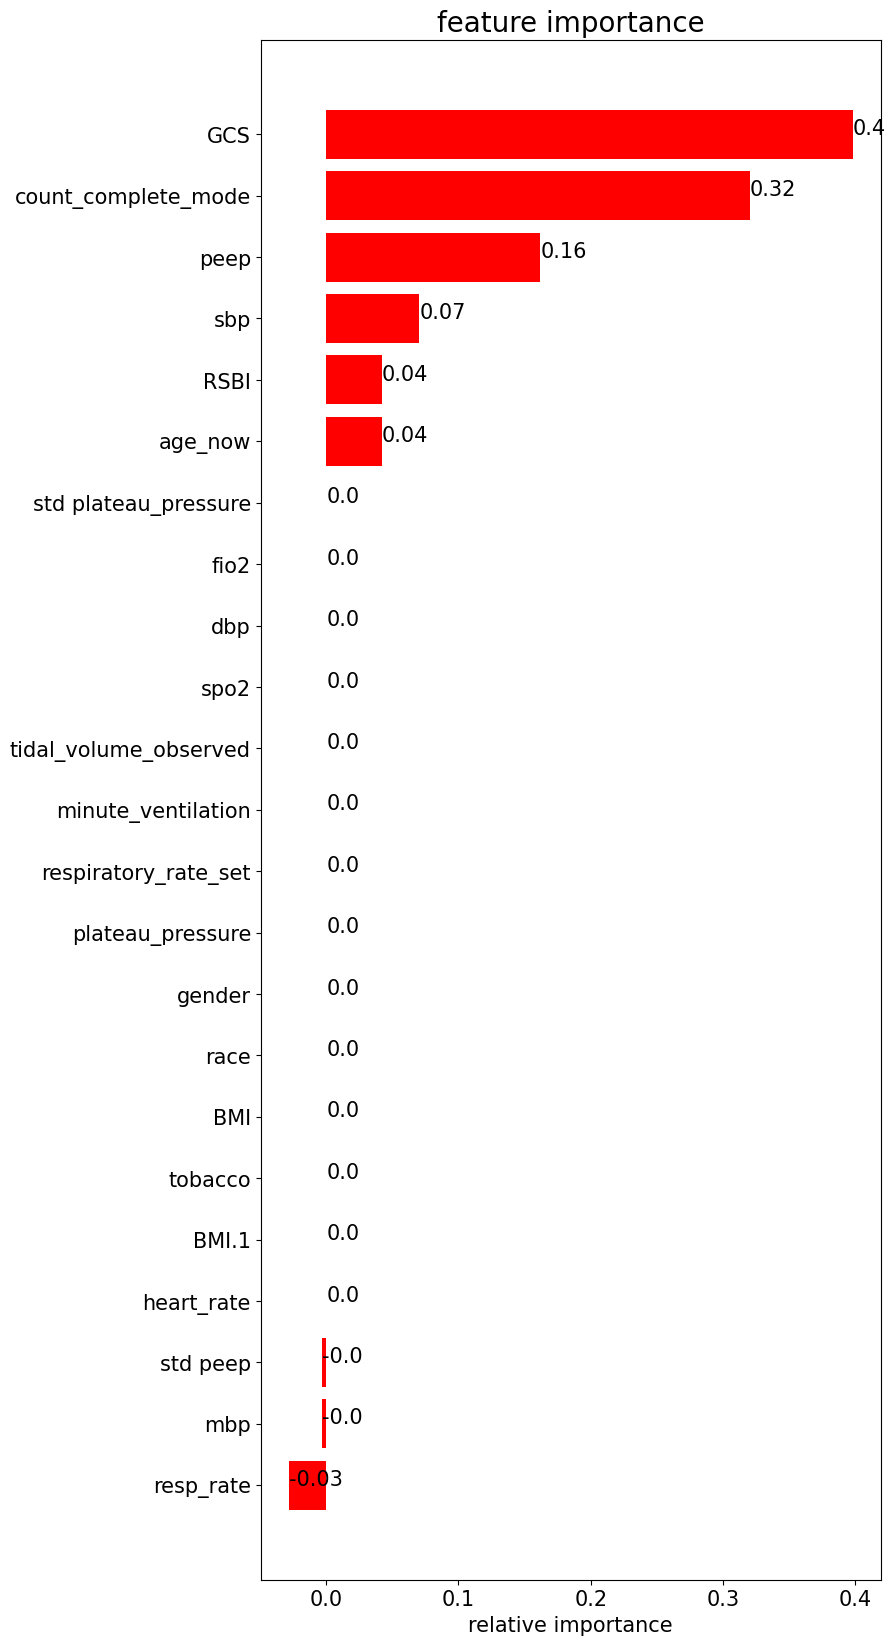

using test to compute feature_importance


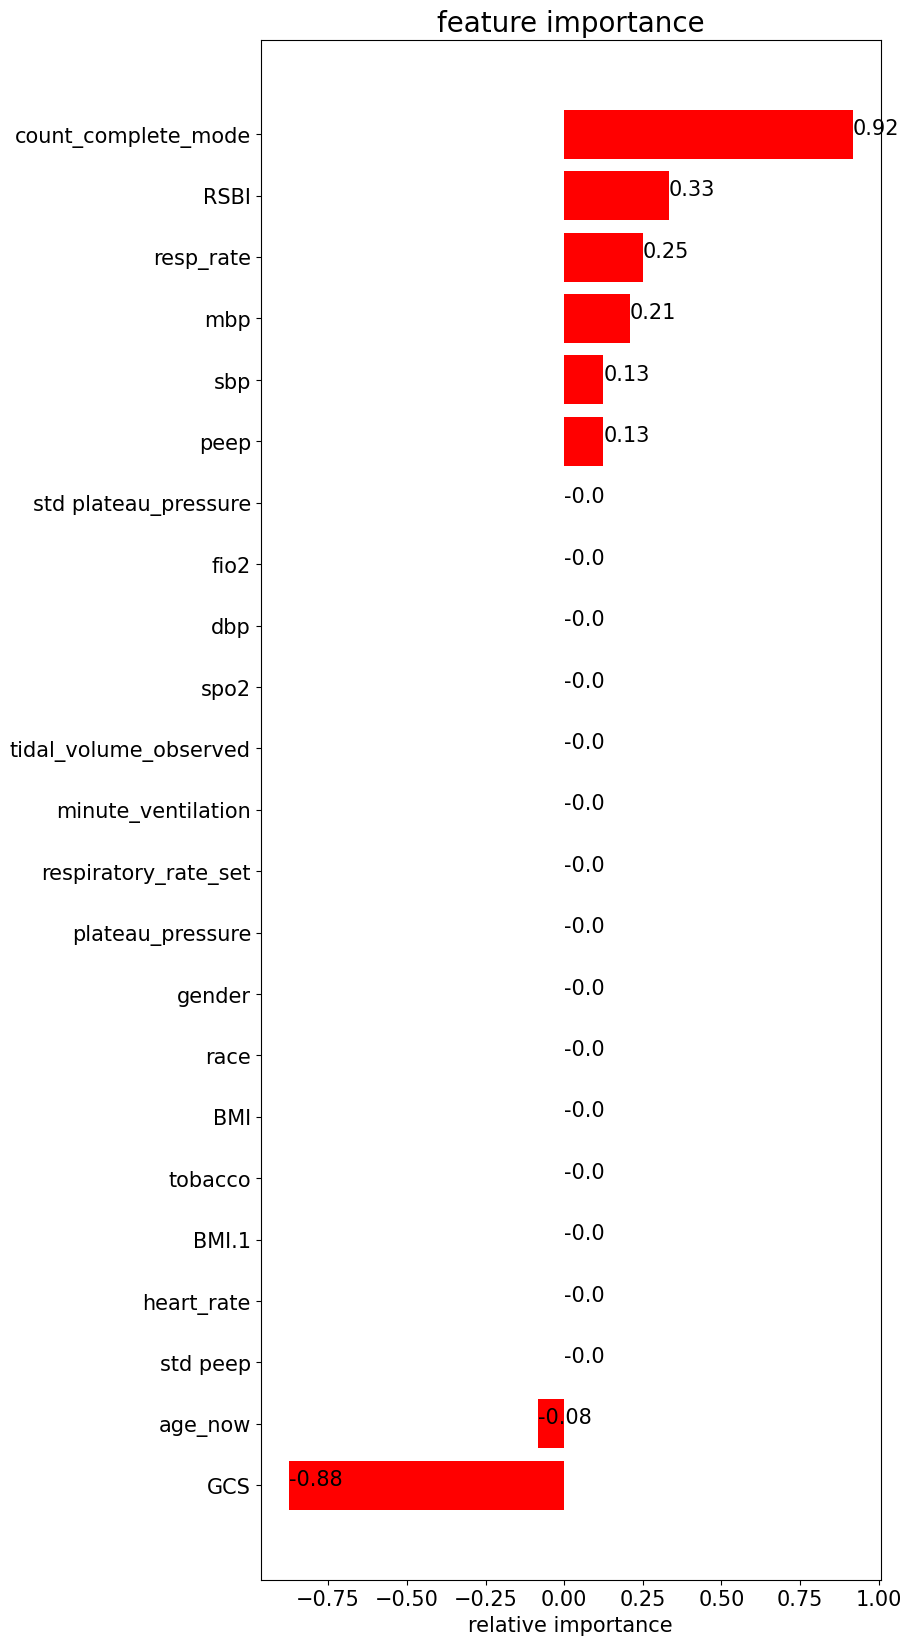

In [35]:
#step4 XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#print("before weaning hour =", print_before_weaning_hr)

"""
Model = xgb.XGBClassifier()
param_grid =  {'n_estimators':np.arange(7, 20), 'max_depth':np.arange(1, 15), 'min_child_weight':np.arange(1, 16),  'random_state':[42]} #,'subsample':[0.6, 0.7, 0.8],'subsample':[0.5, 0.7, 0.8, 1], 'colsample_bytree':[0.5, 0.7, 0.8, 1]}#,'subsample':[0.5, 0.7, 0.8, 1], 'colsample_bytree':[0.5, 0.7, 0.8, 1]}
#param_grid = {'C':[2], 'kernel':['linear'], 'random_state':[42]}
grid_search = GridSearchCV(estimator=Model, param_grid=param_grid, scoring='roc_auc', error_score='raise')
grid_search.fit(tr_v_X, tr_v_y)
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
xgbModel = grid_search.best_estimator_
"""

#"""
xgbModel = xgb.XGBClassifier(max_depth=1, min_child_weight=12, n_estimators=14, random_state=42)
xgbModel.fit(tr_v_X, tr_v_y)
#"""

# accuracy for tr&v
print("train & v")
acc_function(xgbModel, tr_v_X, tr_v_y)

# accuracy for test
print("test")
acc_function(xgbModel, test_X, test_y)

# feature importance
xgb_importance = xgbModel.feature_importances_
# plot importance
df_xgb_importance = pd.DataFrame(xgb_importance, index=tr_v_X.columns, columns=['Importance'])
df_xgb_importance.sort_values(by='Importance', ascending=False, inplace=True)
df_xgb_importance = df_xgb_importance[:30]
df_xgb_importance.plot(kind='bar', figsize=(12, 6))
plt.title('XGBoost feature importance')

print('using (train and validation) to compute feature_importance')
feature_importance(xgbModel, tr_v_X, tr_v_y)
print('using test to compute feature_importance')
feature_importance(xgbModel, test_X, test_y)

# csv
import csv
csvfile_xgb = open('xgb_for_roc.csv', 'w', newline='')
writer = csv.writer(csvfile_xgb)
writer.writerow(xgbModel.predict_proba(test_X)[:, 1])
csvfile_xgb.close()

[08:54:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


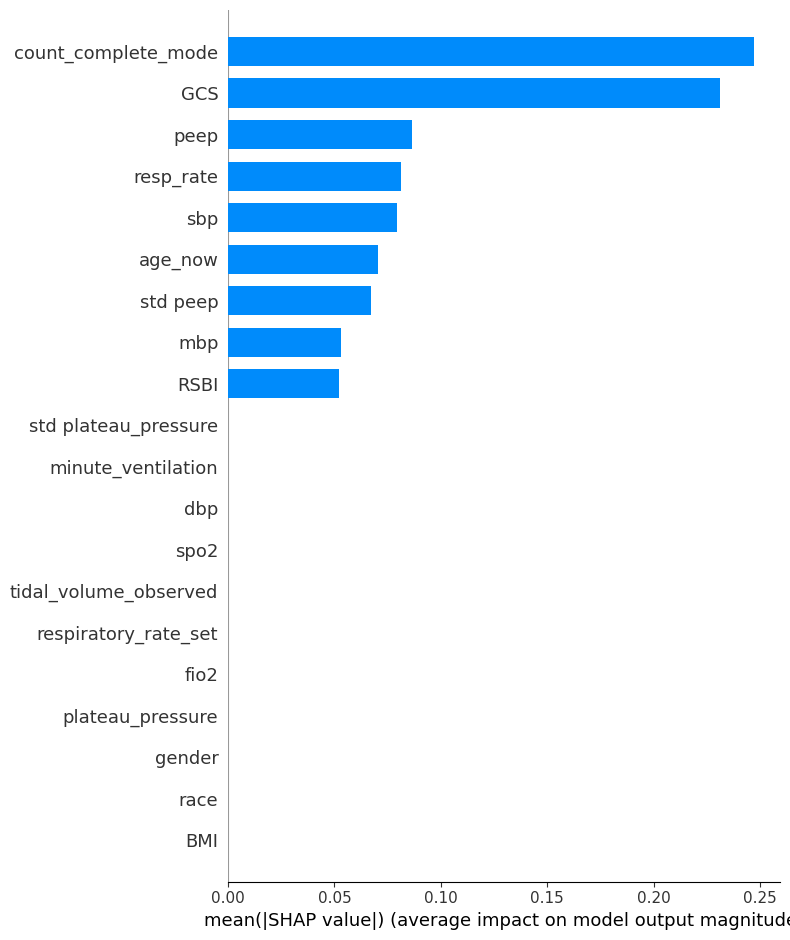

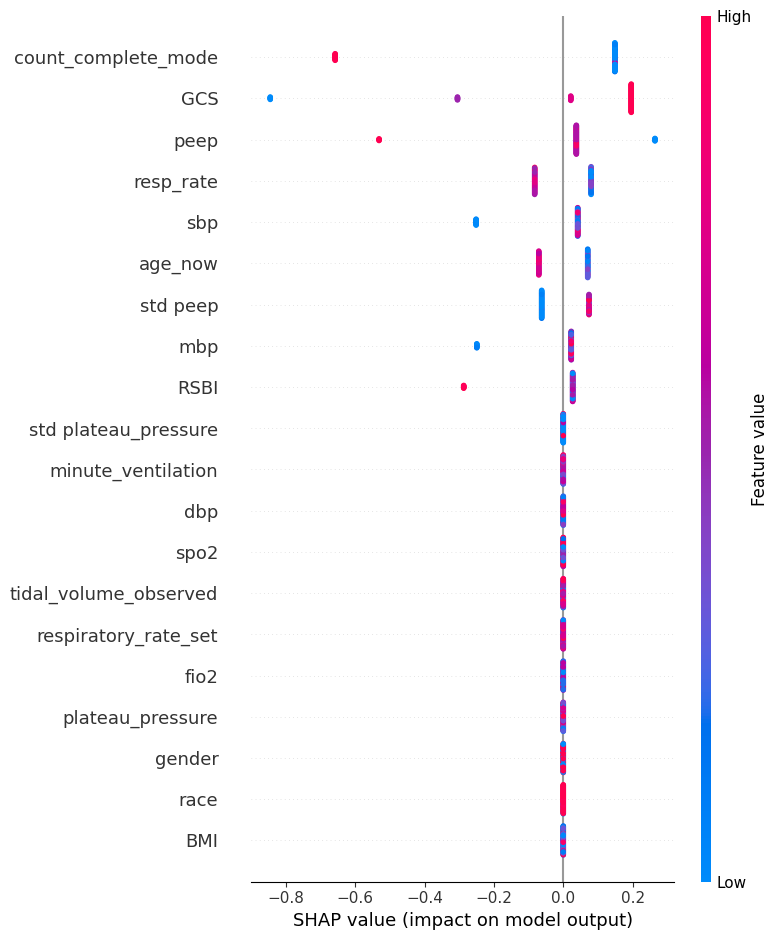

In [41]:
# XGBoost 模型的 SHAP Explainer
explainer_xgb = shap.TreeExplainer(model=xgbModel)
shap_values_xgb = explainer_xgb.shap_values(test_X)

# 總結圖
shap.summary_plot(shap_values_xgb, test_X, plot_type="bar", feature_names=train_X.columns)
shap.summary_plot(shap_values_xgb, test_X, feature_names=train_X.columns)

In [ ]:
print((df_with_one_hot_encoding_drop_not_num.columns))
print((df.columns))

Index(['stay_id', 'age_now', 'weight_kg', 'height_cm', 'tobacco', 'RSBI',
       'minute_ventilation', 'peep', 'fio2', 'tidal_volume_observed',
       'respiratory_rate_set', 'plateau_pressure', 'heart_rate', 'sbp', 'dbp',
       'mbp', 'resp_rate', 'spo2', 'label', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN',
       'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE',
       'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN',
       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',
       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',
       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN',
       'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - DOMINICAN',
       'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN',
       'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN',
       'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY',
       'rac

<class 'pandas.core.series.Series'>
0      1
1      1
2      1
3      1
4      1
      ..
172    0
173    0
174    0
175    0
176    0
Name: label, Length: 177, dtype: int64
177
<class 'pandas.core.series.Series'>
0      0.0
1      0.0
2      0.0
3      1.0
4      1.0
      ... 
269    0.0
270    1.0
271    0.0
272    1.0
273    1.0
Length: 274, dtype: float64
274
274
ROC curve


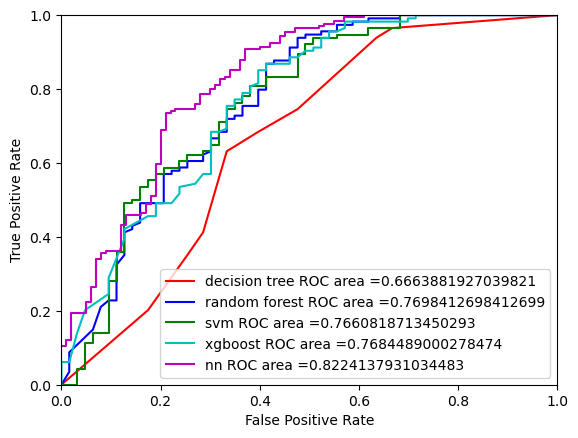

In [ ]:
# multi ROC curve
#def multiROC(pred_y_1, pred_y_2, pred_y_3, pred_y_4, test_y):
def multiROC(pred_y_1, pred_y_2, pred_y_3, pred_y_4, pred_y_5, test_y, nn_label): #
    plt.figure(0).clf()
    print("ROC curve")
    fpr_1, tpr_1, thershold_1 = metrics.roc_curve(test_y, pred_y_1)
    fpr_2, tpr_2, thershold_2 = metrics.roc_curve(test_y, pred_y_2)
    fpr_3, tpr_3, thershold_3 = metrics.roc_curve(test_y, pred_y_3)
    fpr_4, tpr_4, thershold_4 = metrics.roc_curve(test_y, pred_y_4)
    fpr_5, tpr_5, thershold_5 = metrics.roc_curve(nn_label, pred_y_5) #(nn_label, pred_y_5)
    roc_auc_1 = metrics.auc(fpr_1, tpr_1) # auroc
    roc_auc_2 = metrics.auc(fpr_2, tpr_2) # auroc
    roc_auc_3 = metrics.auc(fpr_3, tpr_3) # auroc
    roc_auc_4 = metrics.auc(fpr_4, tpr_4) # auroc
    roc_auc_5 = metrics.auc(fpr_5, tpr_5) # auroc
    #print("roc_auc", roc_auc_1)
    plt.plot(fpr_1, tpr_1, label='decision tree ROC area ='+str(roc_auc_1), color='Red')
    plt.plot(fpr_2, tpr_2, label='random forest ROC area ='+str(roc_auc_2), color='Blue')
    plt.plot(fpr_3, tpr_3, label='svm ROC area ='+str(roc_auc_3), color='g')
    plt.plot(fpr_4, tpr_4, label='xgboost ROC area ='+str(roc_auc_4), color='c')
    plt.plot(fpr_5, tpr_5, label='nn ROC area ='+str(roc_auc_5), color='m')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend()
    #plt.show()


# read file
csvfile_list = ['dt_for_roc.csv', 'rf_for_roc.csv', 'svm_for_roc.csv', 'xgb_for_roc.csv', 'nn_for_roc.csv' ]
pred_y_model = []
for i in np.arange(len(csvfile_list)):
    csvfile = csvfile_list[i]
    with open(csvfile) as csv_f :
        csvReader = csv.reader(csv_f)
        listincsv = list(csvReader)
    if 1: #i != 4:
        listincsv[0] = np.array(listincsv[0], dtype=float)
        listincsv[0] = listincsv[0].tolist()
    else: # i==4
        #print("listincsv", listincsv)
        listincsv = pd.DataFrame(listincsv)
        listincsv[0] = listincsv.iloc[:, [0]]
        #print("listincsv[0]", listincsv[0])
        listincsv[0] = np.array(listincsv[0], dtype=float)
        listincsv[0] = listincsv[0].tolist()
    pred_y_model.append(listincsv[0]) #decisionTreeModel.predict_proba(test_X)[:, 1]
"""
csvfile = 'nn_for_roc_label.csv'
with open(csvfile) as csv_f :
    csvReader = csv.reader(csv_f)
    listincsv = list(csvReader)
nn_label = listincsv
#if i != 4:
nn_label = np.array(listincsv, dtype=float)
nn_label = nn_label.flatten()
nn_label = pd.Series(nn_label.flatten())
#listincsv[0] = listincsv[0].tolist()
"""
# pred_y_model[0]=pred_y_dt, pred_y_model[1]=pred_y_rf, pred_y_model[2]=pred_y_svm, pred_y_model[3]=pred_y_xgb
#pred_y_dt = listincsv[0] #decisionTreeModel.predict_proba(test_X)[:, 1]
#pred_y_rf = randomforestModel.predict_proba(test_X)[:, 1]
# call function
print(type(test_y))
print(test_y)
print(len(pred_y_model[2]))
#print(pred_y_model[4].shape)
print(type(nn_label))
print(nn_label)
print(len(nn_label))
print(len(pred_y_model[4]))
multiROC(pred_y_model[0], pred_y_model[1], pred_y_model[2], pred_y_model[3], pred_y_model[4], test_y, nn_label) #pred_y_svm, pred_y_xgboost,


#print("int", listincsv[0])

#print(decisionTreeModel.predict_proba(test_X)[:, 1])
#print(randomforestModel.predict_proba(test_X)[:, 1])

67